In [3]:
%pylab inline
import time
from collections import defaultdict
import json
import pandas as pd
import os
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout


import numpy as np
import requests
import json 

from datetime import datetime

import urllib

from textblob import TextBlob
#import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Articles about scientists

In [23]:
def load_simple_json(filename):
    print filename
    with open(filename, 'r') as f:
        return json.load(f)

def read_txt(filename,scientists_dir):
    scientist_dict = load_simple_json(filename)

    attention_dict = {}
    for scientist in scientist_dict:
        time_list=[]
        scientist = scientist.rstrip().split('/')[-1]
        txtname = os.path.join(scientists_dir + '\\' + scientist + '.txt') 
        try:
            f = open(txtname)
            for line in f:
                time_list = map(float, line.split(','))
                len_time_list=len(time_list)
                if len_time_list<3074:
                    temp=[np.nan]*(3074-len(time_list))
                    temp.extend(time_list)
                    time_list=temp
            f.close()
            attention_dict.update({scientist:time_list})
        except IOError:
            print txtname
            continue
    return attention_dict


seed = read_txt('seed_creation_date.json',"data\\awarded_scientists_full_views")
base = read_txt('baseline_creation_date.json',"data\\non-awarded_scientists_full_views")

seed_creation_date.json
baseline_creation_date.json
data\non-awarded_scientists_full_views\Julian_Birkinshaw.txt


In [111]:
df_s=pd.DataFrame.from_dict(seed)
df_b=pd.DataFrame.from_dict(base)
df_s.info()
df_b.info()

df_s.set_index(pd.DatetimeIndex(start=datetime(2008,1,1),freq="D",periods=3074),inplace=True)
df_s=df_s.resample('W').sum()
df_s_m=df_s.resample('M').sum()
df_s=df_s.T
df_s_m=df_s_m.T

df_b.set_index(pd.DatetimeIndex(start=datetime(2008,1,1),freq="D",periods=3074),inplace=True)
df_b=df_b.resample('W').sum()
df_b_m=df_b.resample('M').sum()
df_b=df_b.T
df_b_m=df_b_m.T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3074 entries, 0 to 3073
Columns: 262 entries, Ada_Yonath to Zhong_Lin_Wang
dtypes: float64(262)
memory usage: 6.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3074 entries, 0 to 3073
Columns: 275 entries, %C4%90%C3%A0m_Thanh_S%C6%A1n to Zolt%C3%A1n_Szab%C3%B3_(mathematician)
dtypes: float64(275)
memory usage: 6.4 MB


In [238]:
with open("seed_creation_date.json","r") as f:
    sci_aw_dict=json.load(f,encoding="utf-8")
df_sci_aw=pd.DataFrame.from_dict(sci_aw_dict,orient="index")
df_sci_aw.index=df_sci_aw.apply(lambda x: x.name.split("/")[-1],axis=1)
df_sci_aw.Award_date=pd.to_datetime(df_sci_aw.Award_date)
df_sci_aw.Award_date=df_sci_aw.Award_date.apply(lambda x: x.date() )
df_sci_aw.Page_created=pd.to_datetime(df_sci_aw.Page_created)
df_sci_aw.Page_created=df_sci_aw.Page_created.apply(lambda x: x.date() )
#print df_sci_aw.loc["Ada_Yonath"]["Page_created"]

with open("baseline_creation_date.json","r") as f:
    sci_naw_dict=json.load(f,encoding="utf-8")
df_sci_naw=pd.DataFrame.from_dict(sci_naw_dict,orient="index")
df_sci_naw.index=df_sci_naw.apply(lambda x: x.name.split("/")[-1],axis=1)
print df_sci_naw.columns
df_sci_naw.Page_created=pd.to_datetime(df_sci_naw.Page_created)
df_sci_naw.Page_created=df_sci_naw.Page_created.apply(lambda x: x.date() )
#print df_sci_naw.loc["Alan_Aderem"]["Page_created"]

Index([u'Page_created', u'Field', u'Name'], dtype='object')


In [239]:
df_sci_naw.head()

Page_created                   Field  \
%C4%90%C3%A0m_Thanh_S%C6%A1n   2013-02-20                 Physics   
%C5%BDeljko_Reiner             2014-09-22  Physiology or Medicine   
Achim_M%C3%BCller              2006-03-04               Chemistry   
Akiko_Iwasaki                  2015-03-30  Physiology or Medicine   
Alan_Aderem                    2006-10-09  Physiology or Medicine   

                                       Name  
%C4%90%C3%A0m_Thanh_S%C6%A1n  Dam Thanh Son  
%C5%BDeljko_Reiner            Zeljko Reiner  
Achim_M%C3%BCller              Achim Muller  
Akiko_Iwasaki                 Akiko Iwasaki  
Alan_Aderem                     Alan Aderem

In [240]:
df_sci_aw.head()

Award_date Page_created             Name  Gender  \
Ada_Yonath       2009-10-07   2005-06-15       Ada Yonath  female   
Adam_Riess       2010-10-05   2006-07-13    Adam G. Riess    male   
Adrian_Bird      2013-10-07   2009-02-05      Adrian Bird    male   
Aharon_Razin     2013-10-07   2009-10-07     Aharon Razin    male   
Akira_Fujishima  2012-10-10   2008-02-06  Akira Fujishima    male   

                             Award Status                   Field  Year  
Ada_Yonath                   Nobel  alive               Chemistry  2009  
Adam_Riess       Citation Laureate  alive                 Physics  2010  
Adrian_Bird      Citation Laureate  alive  Physiology or Medicine  2013  
Aharon_Razin     Citation Laureate  alive  Physiology or Medicine  2013  
Akira_Fujishima  Citation Laureate  alive               Chemistry  2012

In [241]:
#remove views which corresponds to dates with no article exist
df_s_new=df_s.apply(lambda x:[i if j.date() >= df_sci_aw.loc[x.name]["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)
df_s_new.describe()

2008-01-06   2008-01-13    2008-01-20   2008-01-27   2008-02-03  \
count   165.000000   165.000000    165.000000   165.000000   165.000000   
mean    151.581818   216.000000    273.448485   223.218182   227.139394   
std     317.002964   427.131499    863.348476   461.398815   444.401185   
min       1.000000     3.000000      9.000000     3.000000     7.000000   
25%      35.000000    49.000000     59.000000    53.000000    56.000000   
50%      68.000000    98.000000    105.000000    92.000000   102.000000   
75%     138.000000   198.000000    219.000000   196.000000   197.000000   
max    2612.000000  3241.000000  10371.000000  4241.000000  3782.000000   

        2008-02-10   2008-02-17   2008-02-24   2008-03-02   2008-03-09  \
count   166.000000   166.000000   168.000000   168.000000   168.000000   
mean    218.060241   242.265060   257.404762   232.261905   239.297619   
std     435.940470   493.181523   546.692431   443.252719   459.093960   
min       4.000000     3.000000     7.000000     4.000000    10.000000   
25%      57.000000    57.000000    60.750000    57.750000    55.750000   
50%     102.500000   108.500000    96.000000   104.000000   104.500000   
75%     195.750000   202.750000   205.250000   222.000000   223.250000   
max    3891.000000  4504.000000  3976.000000  3297.000000  3582.000000   

          ...        2016-04-03     2016-04-10   2016-04-17   2016-04-24  \
count     ...        262.000000     262.000000   262.000000   262.000000   
mean      ...        380.282443    1234.274809   392.385496   381.171756   
std       ...        570.031891   13531.499455   605.572602   558.405610   
min       ...          0.000000       0.000000     0.000000     0.000000   
25%       ...         76.250000      72.250000    76.500000    79.250000   
50%       ...        220.500000     188.500000   216.000000   206.000000   
75%       ...        480.000000     487.250000   483.250000   471.750000   
max       ...       6000.000000  219070.000000  6832.000000  5381.000000   

        2016-05-01    2016-05-08    2016-05-15    2016-05-22    2016-05-29  \
count   262.000000    262.000000    262.000000    262.000000    262.000000   
mean    396.351145    442.171756    437.977099    430.152672    442.824427   
std     586.511453   1074.825003   1106.898217   1065.106251   1183.724960   
min       2.000000      3.000000      4.000000      3.000000      6.000000   
25%      80.250000     82.750000     73.500000     79.250000     77.250000   
50%     209.500000    217.500000    213.000000    211.500000    204.000000   
75%     459.750000    473.250000    467.250000    458.500000    456.750000   
max    4806.000000  15284.000000  15732.000000  15299.000000  16160.000000   

        2016-06-05  
count   262.000000  
mean    127.137405  
std     275.174741  
min       1.000000  
25%      23.000000  
50%      58.000000  
75%     137.000000  
max    3649.000000  

[8 rows x 440 columns]

In [242]:
#remove views which corresponds to dates with no article exist
df_b_new=df_b.apply(lambda x:[i if j.date() > df_sci_naw.loc[x.name]["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)
df_b_new.describe()

2008-01-06  2008-01-13  2008-01-20  2008-01-27  2008-02-03  2008-02-10  \
count  103.000000  103.000000  103.000000  103.000000  104.000000  105.000000   
mean    62.475728   83.427184   94.747573   88.427184   92.125000   88.561905   
std     70.947211   92.253020  109.901089  112.077232  110.329576  103.258351   
min      8.000000    7.000000   10.000000    8.000000   13.000000   11.000000   
25%     22.000000   33.000000   39.000000   34.000000   37.500000   35.000000   
50%     41.000000   50.000000   63.000000   57.000000   59.000000   61.000000   
75%     63.000000   89.500000   92.000000   94.500000   90.750000   94.000000   
max    511.000000  642.000000  827.000000  859.000000  851.000000  702.000000   

       2008-02-17   2008-02-24  2008-03-02  2008-03-09     ...      \
count  106.000000   106.000000  106.000000  107.000000     ...       
mean    95.650943   115.358491   98.103774   99.140187     ...       
std    105.080925   262.639321  130.147823  121.684750     ...       
min     11.000000     4.000000    6.000000   11.000000     ...       
25%     39.250000    37.000000   34.250000   38.000000     ...       
50%     62.000000    58.000000   58.500000   59.000000     ...       
75%    111.750000    86.250000   91.500000   95.000000     ...       
max    741.000000  2506.000000  860.000000  848.000000     ...       

        2016-04-03   2016-04-10   2016-04-17   2016-04-24   2016-05-01  \
count   274.000000   274.000000   275.000000   275.000000   275.000000   
mean     89.343066    86.883212    89.916364    90.356364    90.450909   
std     191.618093   160.720792   170.380136   172.944942   180.147467   
min       1.000000     1.000000     0.000000     0.000000     0.000000   
25%      18.000000    17.000000    19.000000    18.000000    18.000000   
50%      37.000000    39.000000    38.000000    39.000000    37.000000   
75%      74.000000    80.500000    83.000000    80.500000    78.500000   
max    1885.000000  1554.000000  1599.000000  1592.000000  1528.000000   

        2016-05-08   2016-05-15   2016-05-22   2016-05-29  2016-06-05  
count   275.000000   275.000000   275.000000   275.000000  275.000000  
mean     89.669091    81.974545    81.970909    80.938182   24.450909  
std     162.715067   151.671524   153.867463   145.905778   44.366674  
min       2.000000     2.000000     3.000000     0.000000    0.000000  
25%      17.000000    17.000000    16.500000    17.500000    5.000000  
50%      39.000000    36.000000    37.000000    34.000000   10.000000  
75%      88.000000    84.500000    81.000000    82.000000   26.000000  
max    1555.000000  1569.000000  1594.000000  1455.000000  407.000000  

[8 rows x 440 columns]

In [243]:
df_s_m_new=df_s_m.apply(lambda x:[i if j.date() > df_sci_aw.loc[x.name]["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)

In [244]:
df_b_m_new=df_b_m.apply(lambda x:[i if j.date() > df_sci_naw.loc[x.name]["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)

## calendar weekly views

In [ ]:
from matplotlib.container import ErrorbarContainer
from matplotlib.legend_handler import HandlerErrorbar

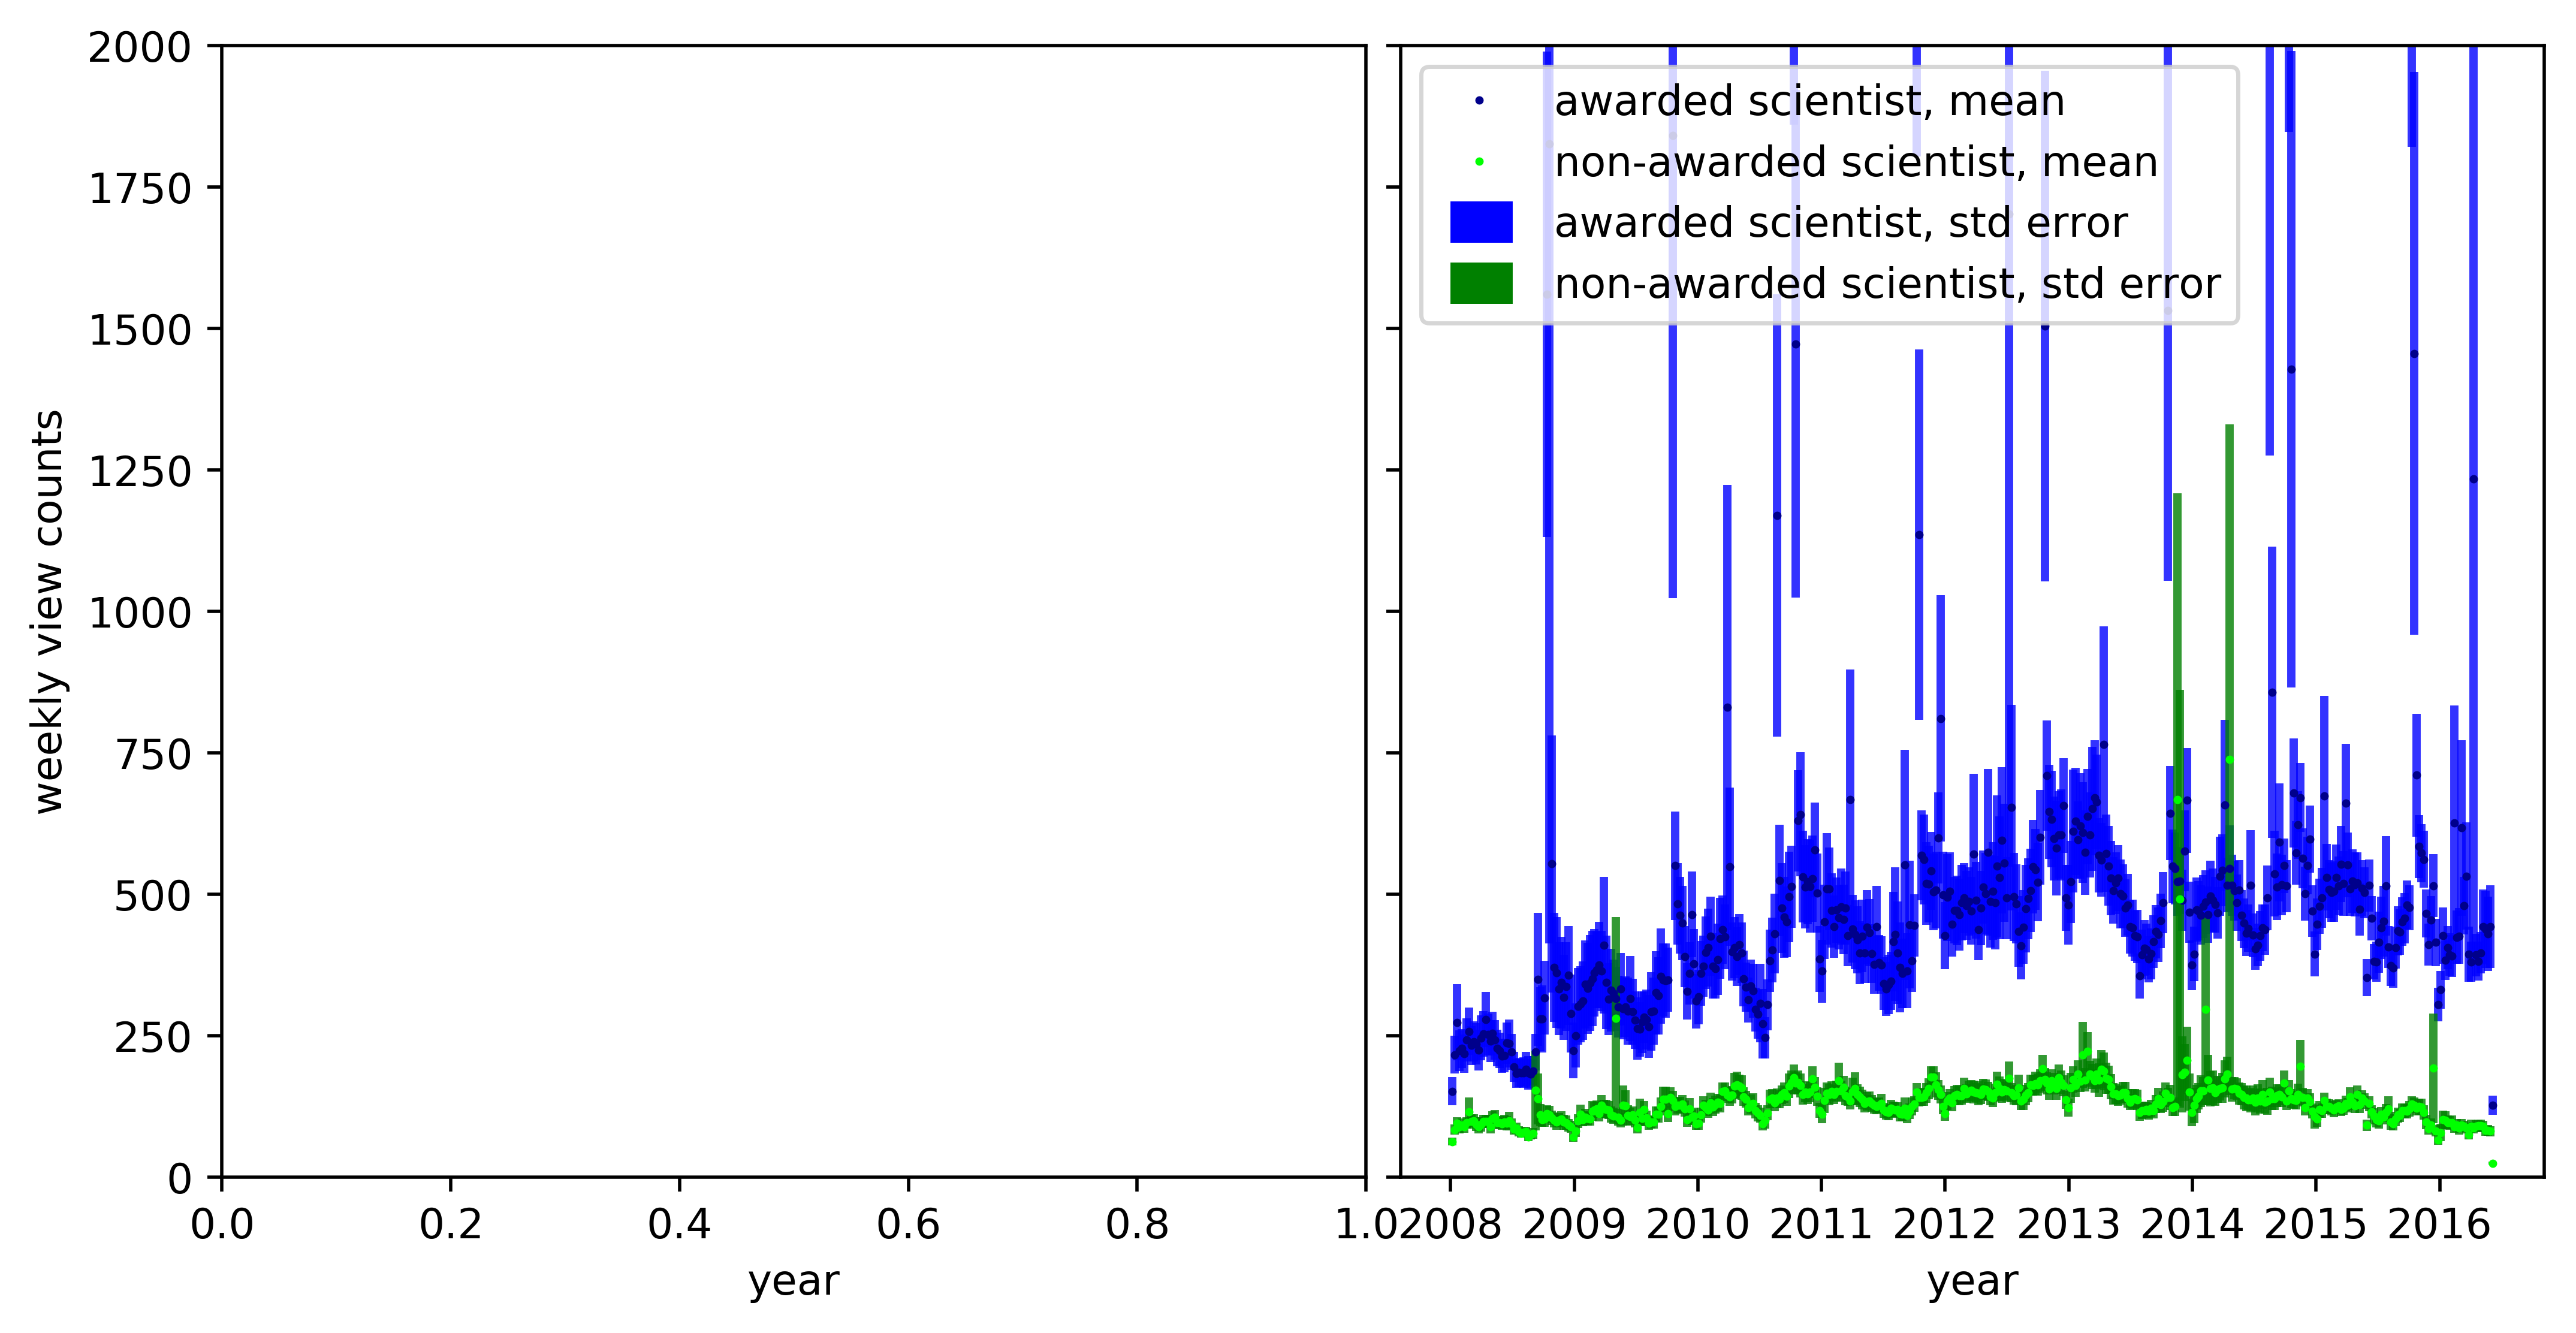

In [372]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True,figsize=[10,5],dpi=500)
ax0.set_ylim(0,2000)
ax0.set_ylabel("weekly view counts")
ax0.set_xlabel("year")
#ax0.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,c="b",alpha=0.7,#lw=2,
#             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
#ax0.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,"darkblue",linewidth = 1,label="awarded scientist, mean")
#ax0.set_xlim(df_s_w_st_aw.iloc[0].name,df_s_w_st_aw.iloc[-1].name)


#ax0.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,c="green",alpha=0.7,#lw=2,
#             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
#ax0.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,"lime",linewidth = 1,label="non-awarded scientist, mean")
#ax0.plot([0,0],[10,175],"r--",label="week of award")

#leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)


ax1.errorbar(df_s_new.columns.values, df_s_new.mean().values, df_s_new.sem().values,c="b",alpha=0.8,lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax1.plot(df_s_new.columns.values, df_s_new.mean().values,".",c="darkblue",ms=2,linewidth = 1,label="awarded scientist, mean")
ax1.errorbar(df_b_new.columns.values, df_b_new.mean().values, df_b_new.sem().values,c="green",alpha=0.8,lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax1.plot(df_b_new.columns.values, df_b_new.mean().values,".",c="lime",ms=2,linewidth = 1,label="non-awarded scientist, mean")
leg=ax1.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
#ax1.set_xlim(df_s_w_st.iloc[0].name,df_s_w_st.iloc[-1].name)
ax1.set_xlabel("year")
plt.subplots_adjust(wspace=0.03, hspace=0.03)
#plt.tight_layout()
plt.show()

## calendar monthly comulated views

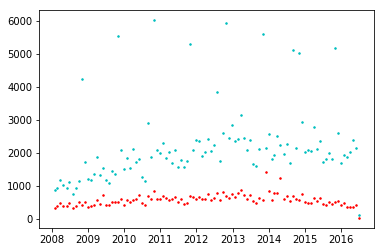

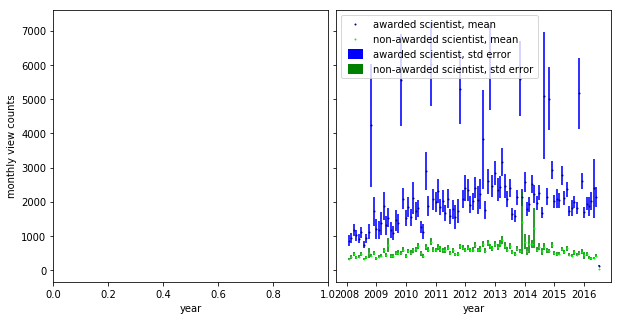

In [246]:
plt.plot(df_s_m_new.columns.values, df_s_m_new.mean().values,".c",ms=3)
plt.plot(df_b_m_new.columns.values, df_b_m_new.mean().values,".r",ms=3)



fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True,figsize=[10,5])
#ax0.set_ylim(0,5000)
ax0.set_ylabel("monthly view counts")
ax0.set_xlabel("year")

ax1.errorbar(df_s_m_new.columns.values, df_s_m_new.mean().values, df_s_m_new.sem().values,c="b",alpha=0.8,lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax1.plot(df_s_m_new.columns.values, df_s_m_new.mean().values,".",c="darkblue",ms=2,linewidth = 1,label="awarded scientist, mean")
ax1.errorbar(df_b_m_new.columns.values, df_b_m_new.mean().values, df_b_m_new.sem().values,c="green",alpha=0.8,lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax1.plot(df_b_m_new.columns.values, df_b_m_new.mean().values,".",c="lime",ms=2,linewidth = 1,label="non-awarded scientist, mean")
leg=ax1.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
#ax1.set_xlim(df_s_w_st.iloc[0].name,df_s_w_st.iloc[-1].name)
ax1.set_xlabel("year")
plt.subplots_adjust(wspace=0.03, hspace=0.03)
#plt.tight_layout()
plt.show()

## 0 week is a week of article creation

In [247]:
df_s_t_new=df_s_new.T
df_s_t_new=df_s_t_new.apply(lambda x: pd.Series(x.dropna().values))
df_s_0week=df_s_t_new.T

df_b_t_new=df_b_new.T
df_b_t_new=df_b_t_new.apply(lambda x: pd.Series(x.dropna().values))
df_b_0week=df_b_t_new.T

df_s_0week.describe()

0             1             2             3            4    \
count    262.000000    262.000000    262.000000    262.000000   262.000000   
mean    1243.332061    464.618321    305.377863    566.068702   246.858779   
std     6210.121768   2270.563557    882.817762   5391.786252   635.311429   
min        0.000000      0.000000      0.000000      0.000000     0.000000   
25%       34.250000     38.250000     43.000000     40.000000    40.250000   
50%       68.500000     80.000000     81.000000     73.000000    75.000000   
75%      133.000000    170.500000    196.000000    186.750000   177.750000   
max    53116.000000  33041.000000  10371.000000  87099.000000  7305.000000   

               5            6            7            8            9    \
count   262.000000   262.000000   262.000000   262.000000   262.000000   
mean    219.721374   229.041985   232.790076   221.507634   255.125954   
std     484.781432   500.852784   511.206527   448.470425   543.463023   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      36.250000    40.000000    37.500000    39.250000    41.000000   
50%      73.000000    74.500000    73.000000    76.000000    80.000000   
75%     174.000000   175.250000   172.250000   178.000000   188.000000   
max    3891.000000  4504.000000  3976.000000  3297.000000  3582.000000   

          ...               430           431          432          433  \
count     ...        168.000000    168.000000   168.000000   166.000000   
mean      ...        455.190476    486.535714   466.119048   454.692771   
std       ...        646.601488    920.636996   695.996936   634.406663   
min       ...         11.000000     12.000000    11.000000    14.000000   
25%       ...        102.000000    107.750000   105.000000   113.500000   
50%       ...        266.500000    247.500000   261.000000   253.500000   
75%       ...        559.500000    552.250000   554.000000   525.750000   
max       ...       6000.000000  10537.000000  6832.000000  5381.000000   

               434          435          436          437          438  \
count   166.000000   165.000000   165.000000   165.000000   165.000000   
mean    461.608434   458.363636   459.593939   446.012121   424.284848   
std     653.697074   632.057838   657.995152   594.252790   568.870305   
min      13.000000     9.000000    12.000000    19.000000    14.000000   
25%     113.500000   103.000000   101.000000   105.000000   103.000000   
50%     255.500000   266.000000   249.000000   276.000000   253.000000   
75%     516.500000   524.000000   510.000000   507.000000   480.000000   
max    4806.000000  5106.000000  5467.000000  4694.000000  4481.000000   

               439  
count   165.000000  
mean    128.666667  
std     179.163277  
min       4.000000  
25%      32.000000  
50%      80.000000  
75%     152.000000  
max    1605.000000  

[8 rows x 440 columns]

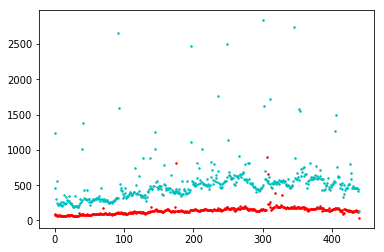

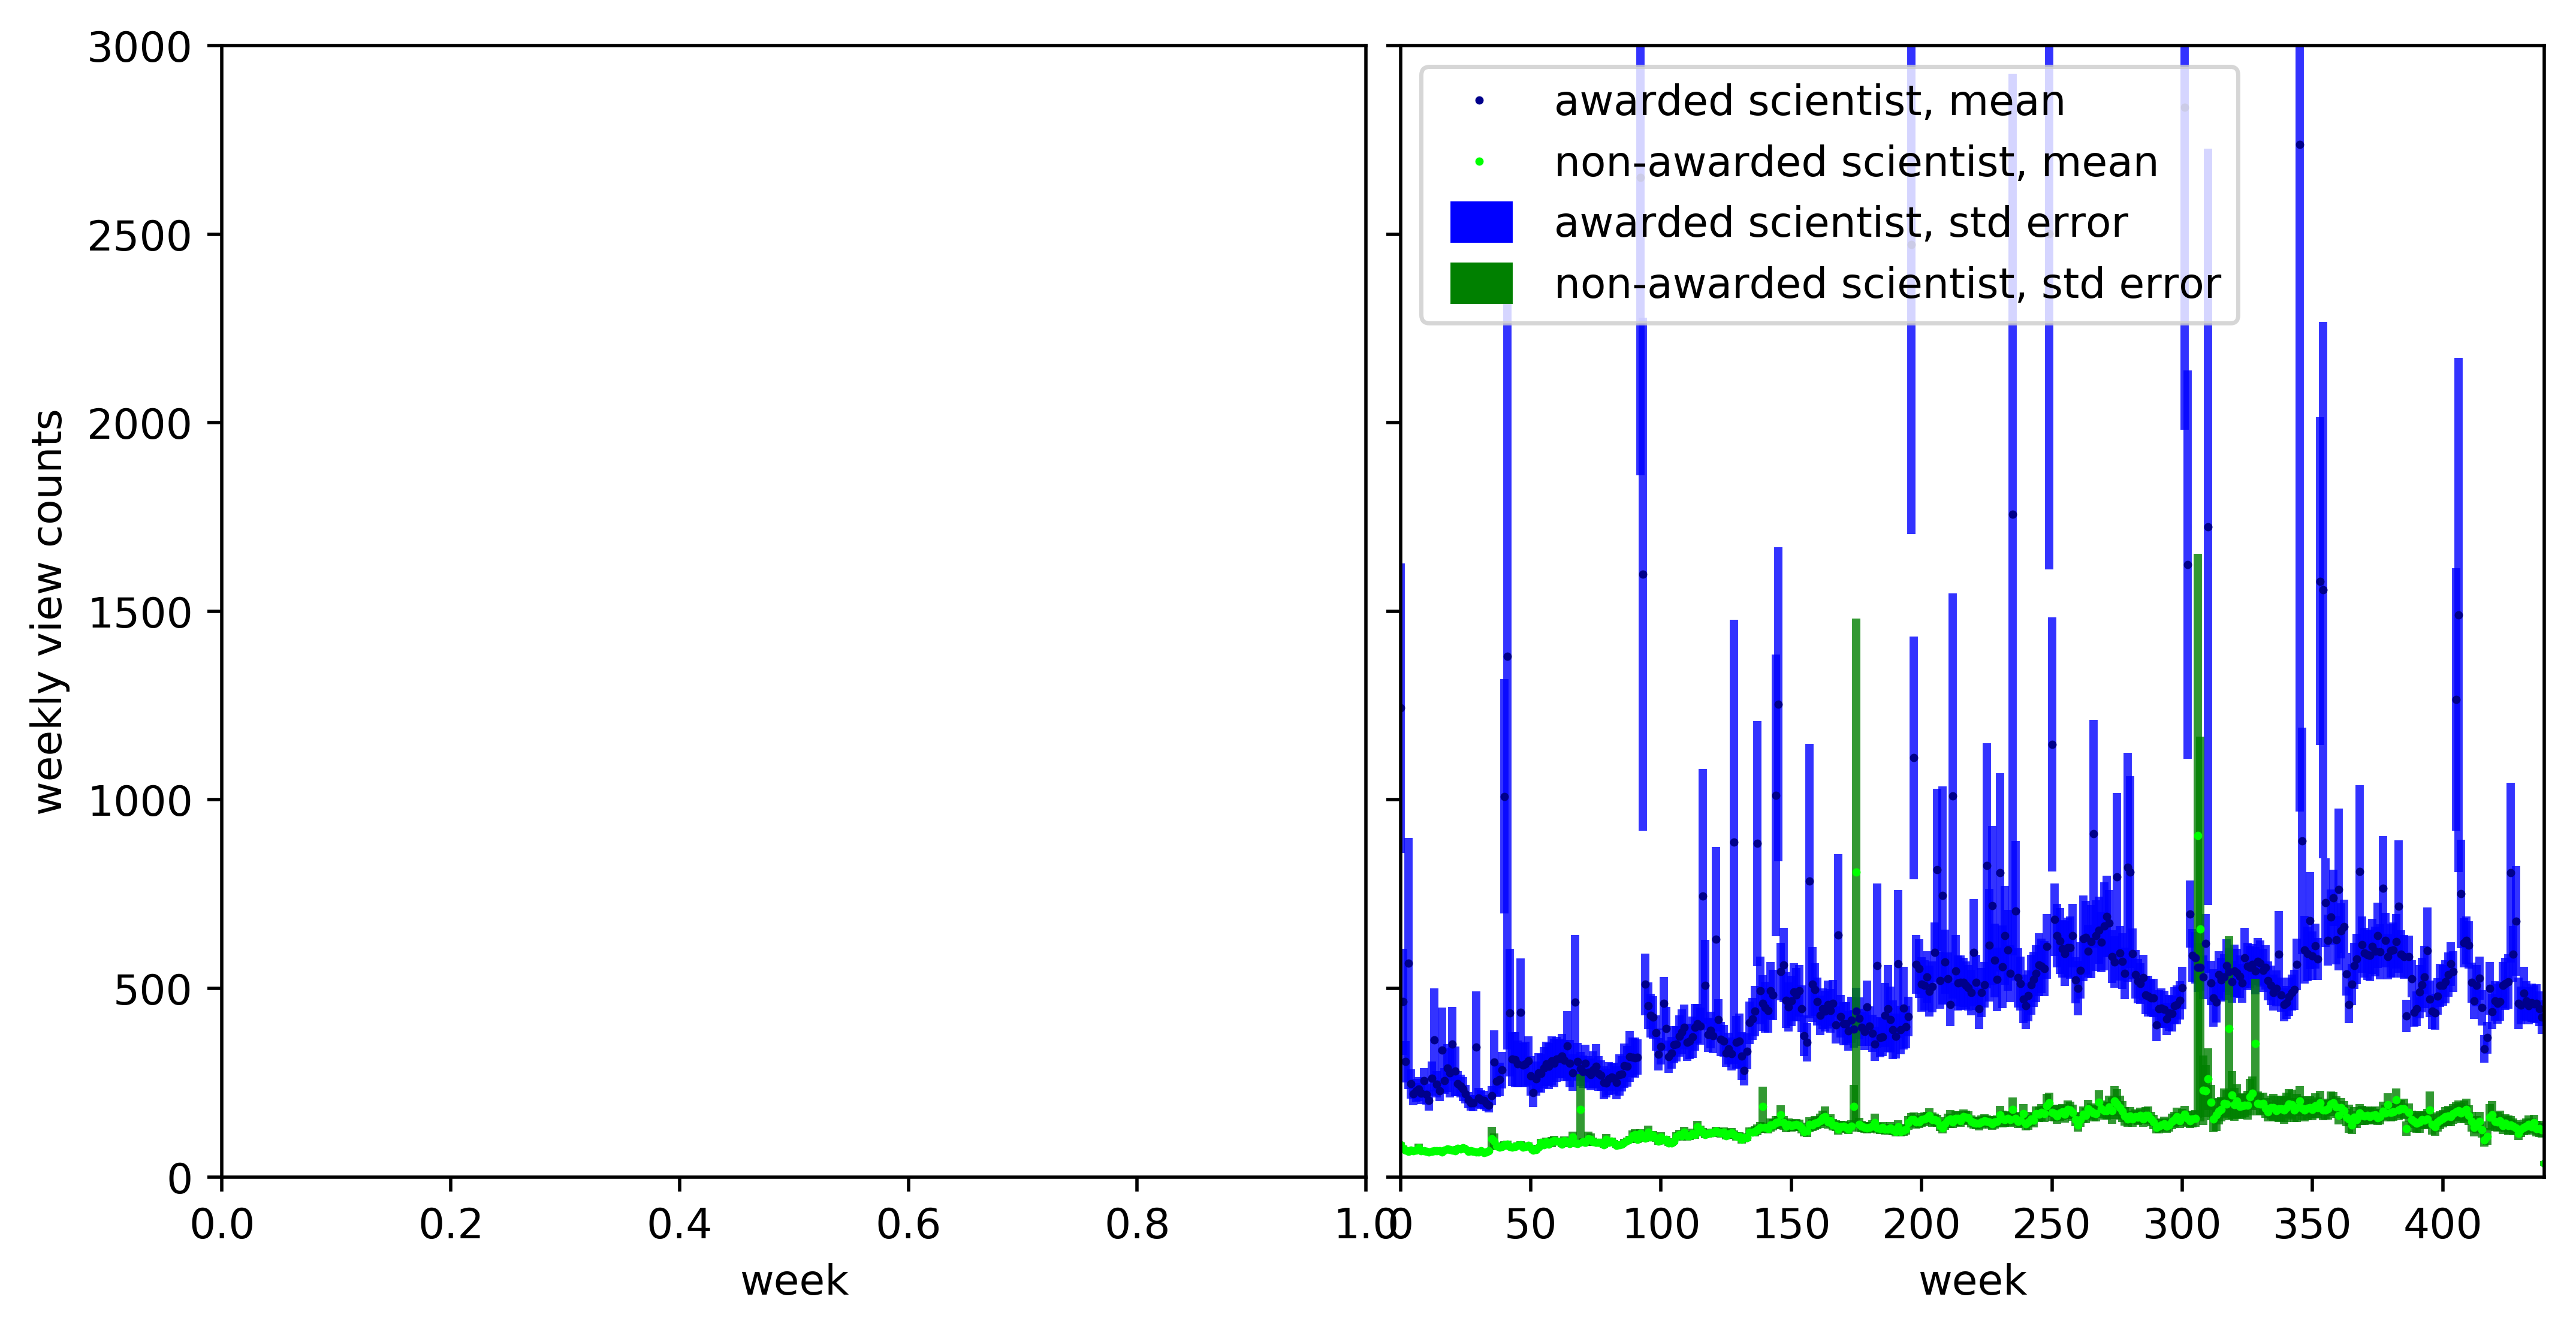

In [371]:
plt.plot(df_b_0week.columns.values, df_b_0week.mean().values,".r",ms=3)
plt.plot(df_s_0week.columns.values, df_s_0week.mean().values,".c",ms=3)

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True,figsize=[10,5],dpi=500)
ax0.set_ylim(0,3000)
ax1.set_xlim(df_s_0week.columns[0],df_s_0week.columns[-1])
ax0.set_ylabel("weekly view counts")
ax0.set_xlabel("week")

ax1.errorbar(df_s_0week.columns.values, df_s_0week.mean().values, df_s_0week.sem().values,c="b",alpha=0.8,lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax1.plot(df_s_0week.columns.values, df_s_0week.mean().values,".",c="darkblue",ms=2,linewidth = 1,label="awarded scientist, mean")
ax1.errorbar(df_b_0week.columns.values, df_b_0week.mean().values, df_b_0week.sem().values,c="green",alpha=0.8,lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax1.plot(df_b_0week.columns.values, df_b_0week.mean().values,".",c="lime",ms=2,linewidth = 1,label="non-awarded scientist, mean")
leg=ax1.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax1.set_xlim(df_s_0week.columns[0],df_s_0week.columns[-1])
ax1.set_xlabel("week")
#ax1.set_title('Length of article; 0 week is the week when the article about scientists was created')
plt.subplots_adjust(wspace=0.03, hspace=0.03)
#plt.tight_layout()
plt.show()

## 0 week is award day

In [491]:
df_s_w_aw=pd.DataFrame(columns=["time_w","views","article","week"])

for article_name,series in df_s_new.iterrows():
    #print article_name,series # s series day - views
    #print article_name
    created=df_sci_aw.loc[article_name]["Page_created"]
    index=pd.date_range(start=df_sci_aw.loc[article_name].Award_date,end=datetime(2016,6,5),freq="W")
    index2=pd.date_range(end=df_sci_aw.loc[article_name].Award_date,start=datetime(2008,1,6),freq="W")
    #index2=pd.date_range(end=df_sci_aw.loc[article_name].Award_date,start=created,freq="W")
    
    df1_1=pd.DataFrame(index,columns=["time_w"])
    df1_1.time_w=df1_1.time_w.apply(lambda x: x.date() )
    #if  created after award
    if (created - df_sci_aw.loc[article_name].Award_date)>(created -created):
        #df1_1=df1_1[df1_1.time_w>=created]
        #s=series.dropna()
        df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        df1_2["views"]=df1_2.time_w.apply(lambda x: series.loc[x] if x in series.index else None)
        #df1=df1_1[["time_w","views"]]
        df1=pd.concat([df1_1,df1_2])
        print article_name
        print df_sci_aw.loc[article_name].Award_date
        print created
        print df1
        print "==> created after award"
    else:
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        df1_2["views"]=df1_2.time_w.apply(lambda x: series.loc[x] if x in series.index else None)
        df1=pd.concat([df1_1,df1_2])
        
    df1["article"]=article_name
    df1["week"]=df1.index
    df_s_w_aw=pd.concat([df_s_w_aw,df1])

Bernd_Giese
2009-10-07
2009-10-10
         time_w  views
 0   2009-10-11   25.0
 1   2009-10-18   44.0
 2   2009-10-25   24.0
 3   2009-11-01   30.0
 4   2009-11-08   17.0
 5   2009-11-15   23.0
 6   2009-11-22   34.0
 7   2009-11-29   22.0
 8   2009-12-06   15.0
 9   2009-12-13   21.0
 10  2009-12-20   15.0
 11  2009-12-27   11.0
 12  2010-01-03   16.0
 13  2010-01-10   16.0
 14  2010-01-17   27.0
 15  2010-01-24   61.0
 16  2010-01-31   23.0
 17  2010-02-07   18.0
 18  2010-02-14   20.0
 19  2010-02-21   20.0
 20  2010-02-28   26.0
 21  2010-03-07   22.0
 22  2010-03-14   45.0
 23  2010-03-21   36.0
 24  2010-03-28   79.0
 25  2010-04-04   42.0
 26  2010-04-11   52.0
 27  2010-04-18   47.0
 28  2010-04-25   36.0
 29  2010-05-02   38.0
..          ...    ...
-30  2009-03-15    NaN
-29  2009-03-22    NaN
-28  2009-03-29    NaN
-27  2009-04-05    NaN
-26  2009-04-12    NaN
-25  2009-04-19    NaN
-24  2009-04-26    NaN
-23  2009-05-03    NaN
-22  2009-05-10    NaN
-21  2009-05-17    NaN


In [1315]:
df_s_w_aw[df_s_w_aw.week==-406]

time_w  views            article  week  all_topics_len  \
-406  2008-01-06    NaN  Charles_F._Manski  -406             8.0   
-406  2008-01-06   75.0       John_A._List  -406            19.0   
-406  2008-01-06   27.0   Richard_Blundell  -406             5.0   

      topics_at_time   views_mean    views_sem  
-406             8.0  4784.000000  3035.481087  
-406            19.0  4002.214286  1700.090228  
-406             5.0  2967.400000  1066.481392

In [1314]:
df_s_w_aw[df_s_w_aw.week==-405]

time_w  views                          article  week  \
-405  2008-01-06   23.0               Arthur_B._McDonald  -405   
-405  2008-01-06    NaN                      Aziz_Sancar  -405   
-405  2008-01-06   42.0              Carolyn_R._Bertozzi  -405   
-405  2008-01-13    NaN                Charles_F._Manski  -405   
-405  2008-01-06   41.0                   Deborah_S._Jin  -405   
-405  2008-01-06    NaN           Emmanuelle_Charpentier  -405   
-405  2008-01-06   25.0                    Ferenc_Krausz  -405   
-405  2008-01-06    NaN                Jeffrey_I._Gordon  -405   
-405  2008-01-06    NaN                  Jennifer_Doudna  -405   
-405  2008-01-13  120.0                     John_A._List  -405   
-405  2008-01-06  120.0               John_B._Goodenough  -405   
-405  2008-01-06    NaN                   Kazutoshi_Mori  -405   
-405  2008-01-06   69.0            M_Stanley_Whittingham  -405   
-405  2008-01-06    NaN                      Paul_Corkum  -405   
-405  2008-01-06   10.0                  Paul_L._Modrich  -405   
-405  2008-01-06   27.0                     Peter_Walter  -405   
-405  2008-01-13   23.0                 Richard_Blundell  -405   
-405  2008-01-06    NaN               Satoshi_%C5%8Cmura  -405   
-405  2008-01-06  110.0                 Shafi_Goldwasser  -405   
-405  2008-01-06    NaN                 Shimon_Sakaguchi  -405   
-405  2008-01-06    NaN                   Takaaki_Kajita  -405   
-405  2008-01-06    NaN                    Tomas_Lindahl  -405   
-405  2008-01-06    NaN                        Tu_Youyou  -405   
-405  2008-01-06    NaN  William_C._Campbell_(scientist)  -405   
-405  2008-01-06    NaN                   Zhong_Lin_Wang  -405   

      all_topics_len  topics_at_time    views_mean     views_sem  
-405             8.0             8.0  15781.375000   5894.098028  
-405            13.0            13.0   2518.769231    980.114934  
-405            15.0            15.0  10685.583333   3648.721790  
-405             8.0             8.0   8084.428571   5423.989609  
-405             3.0             3.0   6812.333333   5052.437047  
-405             9.0             9.0  11641.400000   6420.952239  
-405             6.0             6.0   3887.200000   2246.607763  
-405            17.0            17.0   2722.000000   1355.709392  
-405            18.0            18.0   2370.933333    970.532718  
-405            19.0            19.0   6659.642857   2930.934968  
-405            19.0            19.0   5961.875000   1622.916423  
-405             3.0             3.0   1727.666667   1071.406760  
-405             1.0             1.0   4348.000000           NaN  
-405             3.0             2.0    297.000000           NaN  
-405             3.0             3.0  14612.000000  11093.979193  
-405             8.0             8.0   5075.375000   1683.287090  
-405             5.0             5.0   4879.400000   1855.468825  
-405            10.0            10.0   6491.500000   1565.489118  
-405            11.0            11.0   2804.090909   1413.493457  
-405             6.0             6.0   9664.000000   4606.837238  
-405             4.0             4.0   2024.750000   1015.955410  
-405            10.0            10.0   1636.800000    692.398501  
-405            38.0            38.0   2367.838710    575.861024  
-405            16.0            16.0   4081.461538   1267.960262  
-405             6.0             5.0   6516.000000   5139.056950

In [1312]:
print df_s_w_st_aw
s_w_st_dict

defaultdict(None,
            {-406L: {'count': 2, 'mean_w': 51.0, 'std_1': 23.999999999999996},
             -405L: {'count': 11,
              'mean_w': 55.45454545454545,
              'std_1': 12.717463752553835},
             -404L: {'count': 11,
              'mean_w': 75.0909090909091,
              'std_1': 17.96787767375918},
             -403L: {'count': 11, 'mean_w': 81.0, 'std_1': 18.39515746553473},
             -402L: {'count': 11,
              'mean_w': 76.18181818181819,
              'std_1': 16.630649788769354},
             -401L: {'count': 11,
              'mean_w': 74.72727272727273,
              'std_1': 16.773946740591445},
             -400L: {'count': 11,
              'mean_w': 75.81818181818181,
              'std_1': 18.151793390896259},
             -399L: {'count': 11,
              'mean_w': 80.72727272727273,
              'std_1': 20.356857637969618},
             -398L: {'count': 12, 'mean_w': 81.5, 'std_1': 21.201593707963934},
             -397L: 

In [1306]:
#group data by week number
df_s_w_aw.info()
g=df_s_w_aw.groupby("week")
s_w_st_dict=defaultdict()
for week_name,series in g:
    s_w_st_dict[week_name]={"mean_w":series.views.mean(),"std_1":series.views.sem(),
                            "count":series[~series.views.isnull()].views.count()}
#create df
df_s_w_st_aw=pd.DataFrame.from_dict(s_w_st_dict,orient="index")
print len(df_s_w_st_aw)
df_s_w_st_aw=df_s_w_st_aw[df_s_w_st_aw["count"]>10]
print len(df_s_w_st_aw)
df_s_w_st_aw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115280 entries, 0 to -1
Data columns (total 8 columns):
time_w            115280 non-null object
views             99357 non-null float64
article           115280 non-null object
week              115280 non-null object
all_topics_len    115280 non-null float64
topics_at_time    115280 non-null float64
views_mean        112164 non-null float64
views_sem         107342 non-null float64
dtypes: float64(5), object(3)
memory usage: 10.4+ MB
834
805
<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, -405 to 399
Data columns (total 3 columns):
count     805 non-null int64
mean_w    805 non-null float64
std_1     805 non-null float64
dtypes: float64(2), int64(1)
memory usage: 25.2 KB


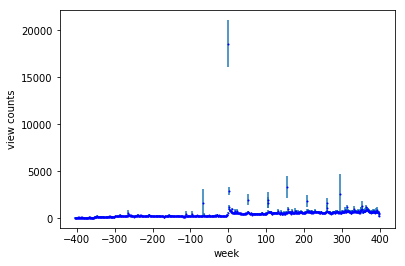

In [1307]:
plt.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,linestyle='None')
plt.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,".b",linewidth = 1,ms=2)
#plt.xlim(0,df_s_w_st.iloc[-1].name)
#plt.ylim(0,5000)
plt.xlabel("week")
plt.ylabel("view counts");

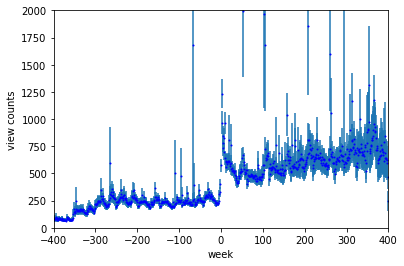

In [1308]:
plt.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,linestyle='None')
plt.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,".b",ms=2)
plt.xlim(-400,400)
plt.ylim(0,2000)
plt.xlabel("week")
plt.ylabel("view counts");

## Non-awarded scientists

In [344]:
df_b_new.head()

2008-01-06  2008-01-13  2008-01-20  2008-01-27  \
%C4%90%C3%A0m_Thanh_S%C6%A1n         NaN         NaN         NaN         NaN   
%C5%BDeljko_Reiner                   NaN         NaN         NaN         NaN   
Achim_M%C3%BCller                   60.0       112.0        77.0        25.0   
Akiko_Iwasaki                        NaN         NaN         NaN         NaN   
Alan_Aderem                         19.0        24.0        40.0        28.0   

                              2008-02-03  2008-02-10  2008-02-17  2008-02-24  \
%C4%90%C3%A0m_Thanh_S%C6%A1n         NaN         NaN         NaN         NaN   
%C5%BDeljko_Reiner                   NaN         NaN         NaN         NaN   
Achim_M%C3%BCller                   74.0        98.0        47.0        39.0   
Akiko_Iwasaki                        NaN         NaN         NaN         NaN   
Alan_Aderem                         27.0        37.0        36.0        35.0   

                              2008-03-02  2008-03-09     ...      2016-04-03  \
%C4%90%C3%A0m_Thanh_S%C6%A1n         NaN         NaN     ...          1885.0   
%C5%BDeljko_Reiner                   NaN         NaN     ...           125.0   
Achim_M%C3%BCller                   30.0        55.0     ...            22.0   
Akiko_Iwasaki                        NaN         NaN     ...            18.0   
Alan_Aderem                         25.0        48.0     ...            36.0   

                              2016-04-10  2016-04-17  2016-04-24  2016-05-01  \
%C4%90%C3%A0m_Thanh_S%C6%A1n        94.0       159.0       101.0       101.0   
%C5%BDeljko_Reiner                 166.0       152.0       163.0       129.0   
Achim_M%C3%BCller                   25.0        14.0        21.0        25.0   
Akiko_Iwasaki                       22.0        15.0        39.0        33.0   
Alan_Aderem                         29.0        12.0        20.0        18.0   

                              2016-05-08  2016-05-15  2016-05-22  2016-05-29  \
%C4%90%C3%A0m_Thanh_S%C6%A1n        93.0        88.0        78.0        98.0   
%C5%BDeljko_Reiner                 136.0       142.0       171.0       131.0   
Achim_M%C3%BCller                   31.0        28.0        17.0        18.0   
Akiko_Iwasaki                       20.0        30.0        43.0        34.0   
Alan_Aderem                         21.0        26.0        20.0        16.0   

                              2016-06-05  
%C4%90%C3%A0m_Thanh_S%C6%A1n        20.0  
%C5%BDeljko_Reiner                  45.0  
Achim_M%C3%BCller                    9.0  
Akiko_Iwasaki                       15.0  
Alan_Aderem                          5.0  

[5 rows x 440 columns]

In [345]:
df_sci_naw.head()

Page_created                   Field  \
%C4%90%C3%A0m_Thanh_S%C6%A1n   2013-02-20                 Physics   
%C5%BDeljko_Reiner             2014-09-22  Physiology or Medicine   
Achim_M%C3%BCller              2006-03-04               Chemistry   
Akiko_Iwasaki                  2015-03-30  Physiology or Medicine   
Alan_Aderem                    2006-10-09  Physiology or Medicine   

                                       Name  
%C4%90%C3%A0m_Thanh_S%C6%A1n  Dam Thanh Son  
%C5%BDeljko_Reiner            Zeljko Reiner  
Achim_M%C3%BCller              Achim Muller  
Akiko_Iwasaki                 Akiko Iwasaki  
Alan_Aderem                     Alan Aderem

In [351]:
#assign random day

def random_date(start, end, position=None):
    start, end = pd.Timestamp(start), pd.Timestamp(end)
    delta = (end - start).total_seconds()
    if position is None:
        offset = np.random.uniform(0., delta)
    else:
        offset = position * delta
    offset = pd.offsets.Second(offset)
    t = start + offset
    return t
#print df_b.timestamp.min()
#print df_b.timestamp.max()
print df_sci_aw.Award_date.min()
print df_sci_aw.Award_date.max()

start=df_sci_aw.Award_date.min()
end=df_sci_aw.Award_date.max()
df_sci_naw["Award_date"]=df_sci_naw.Name.apply(lambda x: random_date(start, end).date() )


2008-03-27
2015-10-12


In [1327]:
df_s_w_naw=pd.DataFrame(columns=["time_w","views","article","week"])

for article_name,series in df_b_new.iterrows():
    #print article_name,series # s series day - views
    print article_name
    created=df_sci_naw.loc[article_name]["Page_created"]
    index=pd.date_range(start=df_sci_naw.loc[article_name].Award_date,end=datetime(2016,6,5),freq="W")
    index2=pd.date_range(end=df_sci_naw.loc[article_name].Award_date,start=datetime(2008,1,6),freq="W")   
    df1_1=pd.DataFrame(index,columns=["time_w"])
    df1_1.time_w=df1_1.time_w.apply(lambda x: x.date() )
    #if  created after award
    if (created - df_sci_naw.loc[article_name].Award_date)>(created - created):
        #df1_1=df1_1[df1_1.time_w>=created]
        ##s=series.dropna()
        #df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        #df1=df1_1[["time_w","views"]]
        #print "==> created after award"
        
        df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        df1_2["views"]=df1_2.time_w.apply(lambda x: series.loc[x] if x in series.index else None)
        #df1=df1_1[["time_w","views"]]
        df1=pd.concat([df1_1,df1_2])
        print article_name
        print df_sci_naw.loc[article_name].Award_date
        print created
        print df1
        print df1_2
        print "==> created after award"
        
    else:
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        df1_2["views"]=df1_2.time_w.apply(lambda x: series.loc[x] if x in series.index else None)
        #print article_name
        #print "created:",created
        #print "award:",df_sci_naw.loc[article_name].Award_date
        df1=pd.concat([df1_1,df1_2])
        
    df1["article"]=article_name
    df1["week"]=df1.index
    df_s_w_naw=pd.concat([df_s_w_naw,df1])

%C4%90%C3%A0m_Thanh_S%C6%A1n
%C5%BDeljko_Reiner
%C5%BDeljko_Reiner
2012-11-18
2014-09-22
         time_w  views
 0   2012-11-18    NaN
 1   2012-11-25    NaN
 2   2012-12-02    NaN
 3   2012-12-09    NaN
 4   2012-12-16    NaN
 5   2012-12-23    NaN
 6   2012-12-30    NaN
 7   2013-01-06    NaN
 8   2013-01-13    NaN
 9   2013-01-20    NaN
 10  2013-01-27    NaN
 11  2013-02-03    NaN
 12  2013-02-10    NaN
 13  2013-02-17    NaN
 14  2013-02-24    NaN
 15  2013-03-03    NaN
 16  2013-03-10    NaN
 17  2013-03-17    NaN
 18  2013-03-24    NaN
 19  2013-03-31    NaN
 20  2013-04-07    NaN
 21  2013-04-14    NaN
 22  2013-04-21    NaN
 23  2013-04-28    NaN
 24  2013-05-05    NaN
 25  2013-05-12    NaN
 26  2013-05-19    NaN
 27  2013-05-26    NaN
 28  2013-06-02    NaN
 29  2013-06-09    NaN
..          ...    ...
-30  2012-04-29    NaN
-29  2012-05-06    NaN
-28  2012-05-13    NaN
-27  2012-05-20    NaN
-26  2012-05-27    NaN
-25  2012-06-03    NaN
-24  2012-06-10    NaN
-23  2012-06-1

Amir_Yacoby
Amir_Yacoby
2011-06-10
2014-04-30
         time_w  views
 0   2011-06-12    NaN
 1   2011-06-19    NaN
 2   2011-06-26    NaN
 3   2011-07-03    NaN
 4   2011-07-10    NaN
 5   2011-07-17    NaN
 6   2011-07-24    NaN
 7   2011-07-31    NaN
 8   2011-08-07    NaN
 9   2011-08-14    NaN
 10  2011-08-21    NaN
 11  2011-08-28    NaN
 12  2011-09-04    NaN
 13  2011-09-11    NaN
 14  2011-09-18    NaN
 15  2011-09-25    NaN
 16  2011-10-02    NaN
 17  2011-10-09    NaN
 18  2011-10-16    NaN
 19  2011-10-23    NaN
 20  2011-10-30    NaN
 21  2011-11-06    NaN
 22  2011-11-13    NaN
 23  2011-11-20    NaN
 24  2011-11-27    NaN
 25  2011-12-04    NaN
 26  2011-12-11    NaN
 27  2011-12-18    NaN
 28  2011-12-25    NaN
 29  2012-01-01    NaN
..          ...    ...
-30  2010-11-14    NaN
-29  2010-11-21    NaN
-28  2010-11-28    NaN
-27  2010-12-05    NaN
-26  2010-12-12    NaN
-25  2010-12-19    NaN
-24  2010-12-26    NaN
-23  2011-01-02    NaN
-22  2011-01-09    NaN
-21  2011-0

Arun_Majumdar
Axel_D._Becke
Axel_Ullrich
Babak_Hassibi
Barry_Everitt
Bengt_R._Holmstr%C3%B6m
Bernhard_Keimer
Bernhard_Keimer
2008-07-30
2014-02-01
         time_w  views
 0   2008-08-03    NaN
 1   2008-08-10    NaN
 2   2008-08-17    NaN
 3   2008-08-24    NaN
 4   2008-08-31    NaN
 5   2008-09-07    NaN
 6   2008-09-14    NaN
 7   2008-09-21    NaN
 8   2008-09-28    NaN
 9   2008-10-05    NaN
 10  2008-10-12    NaN
 11  2008-10-19    NaN
 12  2008-10-26    NaN
 13  2008-11-02    NaN
 14  2008-11-09    NaN
 15  2008-11-16    NaN
 16  2008-11-23    NaN
 17  2008-11-30    NaN
 18  2008-12-07    NaN
 19  2008-12-14    NaN
 20  2008-12-21    NaN
 21  2008-12-28    NaN
 22  2009-01-04    NaN
 23  2009-01-11    NaN
 24  2009-01-18    NaN
 25  2009-01-25    NaN
 26  2009-02-01    NaN
 27  2009-02-08    NaN
 28  2009-02-15    NaN
 29  2009-02-22    NaN
..          ...    ...
-30  2008-01-06    NaN
-29  2008-01-13    NaN
-28  2008-01-20    NaN
-27  2008-01-27    NaN
-26  2008-02-03    NaN
-2

Brigitta_Stockinger
2010-09-27
2013-10-11
         time_w  views
 0   2010-10-03    NaN
 1   2010-10-10    NaN
 2   2010-10-17    NaN
 3   2010-10-24    NaN
 4   2010-10-31    NaN
 5   2010-11-07    NaN
 6   2010-11-14    NaN
 7   2010-11-21    NaN
 8   2010-11-28    NaN
 9   2010-12-05    NaN
 10  2010-12-12    NaN
 11  2010-12-19    NaN
 12  2010-12-26    NaN
 13  2011-01-02    NaN
 14  2011-01-09    NaN
 15  2011-01-16    NaN
 16  2011-01-23    NaN
 17  2011-01-30    NaN
 18  2011-02-06    NaN
 19  2011-02-13    NaN
 20  2011-02-20    NaN
 21  2011-02-27    NaN
 22  2011-03-06    NaN
 23  2011-03-13    NaN
 24  2011-03-20    NaN
 25  2011-03-27    NaN
 26  2011-04-03    NaN
 27  2011-04-10    NaN
 28  2011-04-17    NaN
 29  2011-04-24    NaN
..          ...    ...
-30  2010-03-07    NaN
-29  2010-03-14    NaN
-28  2010-03-21    NaN
-27  2010-03-28    NaN
-26  2010-04-04    NaN
-25  2010-04-11    NaN
-24  2010-04-18    NaN
-23  2010-04-25    NaN
-22  2010-05-02    NaN
-21  2010-05-09

Cees_Dekker
Charles_M._Lieber
Chen_Guanrong
Chen_Guanrong
2010-02-08
2014-10-21
         time_w  views
 0   2010-02-14    NaN
 1   2010-02-21    NaN
 2   2010-02-28    NaN
 3   2010-03-07    NaN
 4   2010-03-14    NaN
 5   2010-03-21    NaN
 6   2010-03-28    NaN
 7   2010-04-04    NaN
 8   2010-04-11    NaN
 9   2010-04-18    NaN
 10  2010-04-25    NaN
 11  2010-05-02    NaN
 12  2010-05-09    NaN
 13  2010-05-16    NaN
 14  2010-05-23    NaN
 15  2010-05-30    NaN
 16  2010-06-06    NaN
 17  2010-06-13    NaN
 18  2010-06-20    NaN
 19  2010-06-27    NaN
 20  2010-07-04    NaN
 21  2010-07-11    NaN
 22  2010-07-18    NaN
 23  2010-07-25    NaN
 24  2010-08-01    NaN
 25  2010-08-08    NaN
 26  2010-08-15    NaN
 27  2010-08-22    NaN
 28  2010-08-29    NaN
 29  2010-09-05    NaN
..          ...    ...
-30  2009-07-19    NaN
-29  2009-07-26    NaN
-28  2009-08-02    NaN
-27  2009-08-09    NaN
-26  2009-08-16    NaN
-25  2009-08-23    NaN
-24  2009-08-30    NaN
-23  2009-09-06    NaN


         time_w  views
 0   2014-06-08    NaN
 1   2014-06-15    NaN
 2   2014-06-22    NaN
 3   2014-06-29    NaN
 4   2014-07-06    NaN
 5   2014-07-13    NaN
 6   2014-07-20    NaN
 7   2014-07-27    NaN
 8   2014-08-03    NaN
 9   2014-08-10    NaN
 10  2014-08-17    NaN
 11  2014-08-24    NaN
 12  2014-08-31    NaN
 13  2014-09-07    NaN
 14  2014-09-14    NaN
 15  2014-09-21    NaN
 16  2014-09-28    NaN
 17  2014-10-05    NaN
 18  2014-10-12    NaN
 19  2014-10-19    NaN
 20  2014-10-26    NaN
 21  2014-11-02    NaN
 22  2014-11-09    NaN
 23  2014-11-16    NaN
 24  2014-11-23    NaN
 25  2014-11-30    NaN
 26  2014-12-07    NaN
 27  2014-12-14    NaN
 28  2014-12-21    NaN
 29  2014-12-28    NaN
..          ...    ...
-30  2013-11-10    NaN
-29  2013-11-17    NaN
-28  2013-11-24    NaN
-27  2013-12-01    NaN
-26  2013-12-08    NaN
-25  2013-12-15    NaN
-24  2013-12-22    NaN
-23  2013-12-29    NaN
-22  2014-01-05    NaN
-21  2014-01-12    NaN
-20  2014-01-19    NaN
-19  2014-0

         time_w  views
 0   2011-12-18    NaN
 1   2011-12-25    NaN
 2   2012-01-01    NaN
 3   2012-01-08    NaN
 4   2012-01-15    NaN
 5   2012-01-22    NaN
 6   2012-01-29    NaN
 7   2012-02-05    NaN
 8   2012-02-12    NaN
 9   2012-02-19    NaN
 10  2012-02-26    NaN
 11  2012-03-04    NaN
 12  2012-03-11    NaN
 13  2012-03-18    NaN
 14  2012-03-25    NaN
 15  2012-04-01    NaN
 16  2012-04-08    NaN
 17  2012-04-15    NaN
 18  2012-04-22    NaN
 19  2012-04-29    NaN
 20  2012-05-06    NaN
 21  2012-05-13    NaN
 22  2012-05-20    NaN
 23  2012-05-27    NaN
 24  2012-06-03    NaN
 25  2012-06-10    NaN
 26  2012-06-17    NaN
 27  2012-06-24    NaN
 28  2012-07-01    NaN
 29  2012-07-08    NaN
..          ...    ...
-30  2011-05-22    NaN
-29  2011-05-29    NaN
-28  2011-06-05    NaN
-27  2011-06-12    NaN
-26  2011-06-19    NaN
-25  2011-06-26    NaN
-24  2011-07-03    NaN
-23  2011-07-10    NaN
-22  2011-07-17    NaN
-21  2011-07-24    NaN
-20  2011-07-31    NaN
-19  2011-0

Frank_Glorius
Frank_Glorius
2008-09-24
2014-11-09
         time_w  views
 0   2008-09-28    NaN
 1   2008-10-05    NaN
 2   2008-10-12    NaN
 3   2008-10-19    NaN
 4   2008-10-26    NaN
 5   2008-11-02    NaN
 6   2008-11-09    NaN
 7   2008-11-16    NaN
 8   2008-11-23    NaN
 9   2008-11-30    NaN
 10  2008-12-07    NaN
 11  2008-12-14    NaN
 12  2008-12-21    NaN
 13  2008-12-28    NaN
 14  2009-01-04    NaN
 15  2009-01-11    NaN
 16  2009-01-18    NaN
 17  2009-01-25    NaN
 18  2009-02-01    NaN
 19  2009-02-08    NaN
 20  2009-02-15    NaN
 21  2009-02-22    NaN
 22  2009-03-01    NaN
 23  2009-03-08    NaN
 24  2009-03-15    NaN
 25  2009-03-22    NaN
 26  2009-03-29    NaN
 27  2009-04-05    NaN
 28  2009-04-12    NaN
 29  2009-04-19    NaN
..          ...    ...
-30  2008-03-02    NaN
-29  2008-03-09    NaN
-28  2008-03-16    NaN
-27  2008-03-23    NaN
-26  2008-03-30    NaN
-25  2008-04-06    NaN
-24  2008-04-13    NaN
-23  2008-04-20    NaN
-22  2008-04-27    NaN
-21  20

Graham_Fleming
Guido_Imbens
Guido_Imbens
2010-07-21
2014-04-20
         time_w  views
 0   2010-07-25    NaN
 1   2010-08-01    NaN
 2   2010-08-08    NaN
 3   2010-08-15    NaN
 4   2010-08-22    NaN
 5   2010-08-29    NaN
 6   2010-09-05    NaN
 7   2010-09-12    NaN
 8   2010-09-19    NaN
 9   2010-09-26    NaN
 10  2010-10-03    NaN
 11  2010-10-10    NaN
 12  2010-10-17    NaN
 13  2010-10-24    NaN
 14  2010-10-31    NaN
 15  2010-11-07    NaN
 16  2010-11-14    NaN
 17  2010-11-21    NaN
 18  2010-11-28    NaN
 19  2010-12-05    NaN
 20  2010-12-12    NaN
 21  2010-12-19    NaN
 22  2010-12-26    NaN
 23  2011-01-02    NaN
 24  2011-01-09    NaN
 25  2011-01-16    NaN
 26  2011-01-23    NaN
 27  2011-01-30    NaN
 28  2011-02-06    NaN
 29  2011-02-13    NaN
..          ...    ...
-30  2009-12-27    NaN
-29  2010-01-03    NaN
-28  2010-01-10    NaN
-27  2010-01-17    NaN
-26  2010-01-24    NaN
-25  2010-01-31    NaN
-24  2010-02-07    NaN
-23  2010-02-14    NaN
-22  2010-02-21  

2008-05-15
2013-09-05
          time_w  views
 0    2008-05-18    NaN
 1    2008-05-25    NaN
 2    2008-06-01    NaN
 3    2008-06-08    NaN
 4    2008-06-15    NaN
 5    2008-06-22    NaN
 6    2008-06-29    NaN
 7    2008-07-06    NaN
 8    2008-07-13    NaN
 9    2008-07-20    NaN
 10   2008-07-27    NaN
 11   2008-08-03    NaN
 12   2008-08-10    NaN
 13   2008-08-17    NaN
 14   2008-08-24    NaN
 15   2008-08-31    NaN
 16   2008-09-07    NaN
 17   2008-09-14    NaN
 18   2008-09-21    NaN
 19   2008-09-28    NaN
 20   2008-10-05    NaN
 21   2008-10-12    NaN
 22   2008-10-19    NaN
 23   2008-10-26    NaN
 24   2008-11-02    NaN
 25   2008-11-09    NaN
 26   2008-11-16    NaN
 27   2008-11-23    NaN
 28   2008-11-30    NaN
 29   2008-12-07    NaN
...          ...    ...
 410  2016-03-27    7.0
 411  2016-04-03   19.0
 412  2016-04-10    4.0
 413  2016-04-17    9.0
 414  2016-04-24   16.0
 415  2016-05-01   10.0
 416  2016-05-08   19.0
 417  2016-05-15   13.0
 418  2016-05-22  

Idun_Reiten
Igor_Jurisica
Igor_Jurisica
2013-06-30
2016-04-12
         time_w  views
 0   2013-06-30    NaN
 1   2013-07-07    NaN
 2   2013-07-14    NaN
 3   2013-07-21    NaN
 4   2013-07-28    NaN
 5   2013-08-04    NaN
 6   2013-08-11    NaN
 7   2013-08-18    NaN
 8   2013-08-25    NaN
 9   2013-09-01    NaN
 10  2013-09-08    NaN
 11  2013-09-15    NaN
 12  2013-09-22    NaN
 13  2013-09-29    NaN
 14  2013-10-06    NaN
 15  2013-10-13    NaN
 16  2013-10-20    NaN
 17  2013-10-27    NaN
 18  2013-11-03    NaN
 19  2013-11-10    NaN
 20  2013-11-17    NaN
 21  2013-11-24    NaN
 22  2013-12-01    NaN
 23  2013-12-08    NaN
 24  2013-12-15    NaN
 25  2013-12-22    NaN
 26  2013-12-29    NaN
 27  2014-01-05    NaN
 28  2014-01-12    NaN
 29  2014-01-19    NaN
..          ...    ...
-30  2012-12-09    NaN
-29  2012-12-16    NaN
-28  2012-12-23    NaN
-27  2012-12-30    NaN
-26  2013-01-06    NaN
-25  2013-01-13    NaN
-24  2013-01-20    NaN
-23  2013-01-27    NaN
-22  2013-02-03   

Jean-Luc_Br%C3%A9das
Jean-Marie_Tarascon
Jean-Marie_Tarascon
2011-03-30
2014-12-19
         time_w  views
 0   2011-04-03    NaN
 1   2011-04-10    NaN
 2   2011-04-17    NaN
 3   2011-04-24    NaN
 4   2011-05-01    NaN
 5   2011-05-08    NaN
 6   2011-05-15    NaN
 7   2011-05-22    NaN
 8   2011-05-29    NaN
 9   2011-06-05    NaN
 10  2011-06-12    NaN
 11  2011-06-19    NaN
 12  2011-06-26    NaN
 13  2011-07-03    NaN
 14  2011-07-10    NaN
 15  2011-07-17    NaN
 16  2011-07-24    NaN
 17  2011-07-31    NaN
 18  2011-08-07    NaN
 19  2011-08-14    NaN
 20  2011-08-21    NaN
 21  2011-08-28    NaN
 22  2011-09-04    NaN
 23  2011-09-11    NaN
 24  2011-09-18    NaN
 25  2011-09-25    NaN
 26  2011-10-02    NaN
 27  2011-10-09    NaN
 28  2011-10-16    NaN
 29  2011-10-23    NaN
..          ...    ...
-30  2010-09-05    NaN
-29  2010-09-12    NaN
-28  2010-09-19    NaN
-27  2010-09-26    NaN
-26  2010-10-03    NaN
-25  2010-10-10    NaN
-24  2010-10-17    NaN
-23  2010-10-24    N

Jing_Li_(chemist)
Joan_Massagu%C3%A9_Sol%C3%A9
Joann_E._Manson
Joann_E._Manson
2014-04-29
2014-09-29
         time_w  views
 0   2014-05-04    NaN
 1   2014-05-11    NaN
 2   2014-05-18    NaN
 3   2014-05-25    NaN
 4   2014-06-01    NaN
 5   2014-06-08    NaN
 6   2014-06-15    NaN
 7   2014-06-22    NaN
 8   2014-06-29    NaN
 9   2014-07-06    NaN
 10  2014-07-13    NaN
 11  2014-07-20    NaN
 12  2014-07-27    NaN
 13  2014-08-03    NaN
 14  2014-08-10    NaN
 15  2014-08-17    NaN
 16  2014-08-24    NaN
 17  2014-08-31    NaN
 18  2014-09-07    NaN
 19  2014-09-14    NaN
 20  2014-09-21    NaN
 21  2014-09-28    NaN
 22  2014-10-05   70.0
 23  2014-10-12   76.0
 24  2014-10-19   73.0
 25  2014-10-26   56.0
 26  2014-11-02   88.0
 27  2014-11-09   83.0
 28  2014-11-16   63.0
 29  2014-11-23   91.0
..          ...    ...
-30  2013-10-06    NaN
-29  2013-10-13    NaN
-28  2013-10-20    NaN
-27  2013-10-27    NaN
-26  2013-11-03    NaN
-25  2013-11-10    NaN
-24  2013-11-17    NaN
-2

John_Y._Campbell
Jon_Clardy
Jon_Clardy
2012-12-24
2013-05-15
         time_w  views
 0   2012-12-30    NaN
 1   2013-01-06    NaN
 2   2013-01-13    NaN
 3   2013-01-20    NaN
 4   2013-01-27    NaN
 5   2013-02-03    NaN
 6   2013-02-10    NaN
 7   2013-02-17    NaN
 8   2013-02-24    NaN
 9   2013-03-03    NaN
 10  2013-03-10    NaN
 11  2013-03-17    NaN
 12  2013-03-24    NaN
 13  2013-03-31    NaN
 14  2013-04-07    NaN
 15  2013-04-14    NaN
 16  2013-04-21    NaN
 17  2013-04-28    NaN
 18  2013-05-05    NaN
 19  2013-05-12    NaN
 20  2013-05-19    2.0
 21  2013-05-26    2.0
 22  2013-06-02    3.0
 23  2013-06-09    0.0
 24  2013-06-16    0.0
 25  2013-06-23    0.0
 26  2013-06-30    0.0
 27  2013-07-07    2.0
 28  2013-07-14    0.0
 29  2013-07-21    1.0
..          ...    ...
-30  2012-06-03    NaN
-29  2012-06-10    NaN
-28  2012-06-17    NaN
-27  2012-06-24    NaN
-26  2012-07-01    NaN
-25  2012-07-08    NaN
-24  2012-07-15    NaN
-23  2012-07-22    NaN
-22  2012-07-29    

Kim_Kimoon
2008-05-26
2013-06-18
          time_w  views
 0    2008-06-01    NaN
 1    2008-06-08    NaN
 2    2008-06-15    NaN
 3    2008-06-22    NaN
 4    2008-06-29    NaN
 5    2008-07-06    NaN
 6    2008-07-13    NaN
 7    2008-07-20    NaN
 8    2008-07-27    NaN
 9    2008-08-03    NaN
 10   2008-08-10    NaN
 11   2008-08-17    NaN
 12   2008-08-24    NaN
 13   2008-08-31    NaN
 14   2008-09-07    NaN
 15   2008-09-14    NaN
 16   2008-09-21    NaN
 17   2008-09-28    NaN
 18   2008-10-05    NaN
 19   2008-10-12    NaN
 20   2008-10-19    NaN
 21   2008-10-26    NaN
 22   2008-11-02    NaN
 23   2008-11-09    NaN
 24   2008-11-16    NaN
 25   2008-11-23    NaN
 26   2008-11-30    NaN
 27   2008-12-07    NaN
 28   2008-12-14    NaN
 29   2008-12-21    NaN
...          ...    ...
 410  2016-04-10    9.0
 411  2016-04-17   17.0
 412  2016-04-24   19.0
 413  2016-05-01   13.0
 414  2016-05-08   15.0
 415  2016-05-15   13.0
 416  2016-05-22    7.0
 417  2016-05-29   14.0
 418  2

Matja%C5%BE_Perc
Matja%C5%BE_Perc
2014-08-29
2014-10-04
         time_w  views
 0   2014-08-31    NaN
 1   2014-09-07    NaN
 2   2014-09-14    NaN
 3   2014-09-21    NaN
 4   2014-09-28    NaN
 5   2014-10-05    NaN
 6   2014-10-12    NaN
 7   2014-10-19    NaN
 8   2014-10-26    NaN
 9   2014-11-02    NaN
 10  2014-11-09    NaN
 11  2014-11-16    NaN
 12  2014-11-23    NaN
 13  2014-11-30    NaN
 14  2014-12-07    NaN
 15  2014-12-14    NaN
 16  2014-12-21    NaN
 17  2014-12-28    NaN
 18  2015-01-04    0.0
 19  2015-01-11    0.0
 20  2015-01-18    0.0
 21  2015-01-25    0.0
 22  2015-02-01    0.0
 23  2015-02-08    0.0
 24  2015-02-15    0.0
 25  2015-02-22    0.0
 26  2015-03-01    0.0
 27  2015-03-08    0.0
 28  2015-03-15    0.0
 29  2015-03-22    0.0
..          ...    ...
-30  2014-02-02    NaN
-29  2014-02-09    NaN
-28  2014-02-16    NaN
-27  2014-02-23    NaN
-26  2014-03-02    NaN
-25  2014-03-09    NaN
-24  2014-03-16    NaN
-23  2014-03-23    NaN
-22  2014-03-30    NaN
-

Michele_Parrinello
Michele_Parrinello
2009-12-03
2011-10-11
         time_w  views
 0   2009-12-06    NaN
 1   2009-12-13    NaN
 2   2009-12-20    NaN
 3   2009-12-27    NaN
 4   2010-01-03    NaN
 5   2010-01-10    NaN
 6   2010-01-17    NaN
 7   2010-01-24    NaN
 8   2010-01-31    NaN
 9   2010-02-07    NaN
 10  2010-02-14    NaN
 11  2010-02-21    NaN
 12  2010-02-28    NaN
 13  2010-03-07    NaN
 14  2010-03-14    NaN
 15  2010-03-21    NaN
 16  2010-03-28    NaN
 17  2010-04-04    NaN
 18  2010-04-11    NaN
 19  2010-04-18    NaN
 20  2010-04-25    NaN
 21  2010-05-02    NaN
 22  2010-05-09    NaN
 23  2010-05-16    NaN
 24  2010-05-23    NaN
 25  2010-05-30    NaN
 26  2010-06-06    NaN
 27  2010-06-13    NaN
 28  2010-06-20    NaN
 29  2010-06-27    NaN
..          ...    ...
-30  2009-05-10    NaN
-29  2009-05-17    NaN
-28  2009-05-24    NaN
-27  2009-05-31    NaN
-26  2009-06-07    NaN
-25  2009-06-14    NaN
-24  2009-06-21    NaN
-23  2009-06-28    NaN
-22  2009-07-05    N

Nathan_Seiberg
Nello_Cristianini
Nicholas_Bloom
Nicholas_Bloom
2011-01-27
2014-08-19
         time_w  views
 0   2011-01-30    NaN
 1   2011-02-06    NaN
 2   2011-02-13    NaN
 3   2011-02-20    NaN
 4   2011-02-27    NaN
 5   2011-03-06    NaN
 6   2011-03-13    NaN
 7   2011-03-20    NaN
 8   2011-03-27    NaN
 9   2011-04-03    NaN
 10  2011-04-10    NaN
 11  2011-04-17    NaN
 12  2011-04-24    NaN
 13  2011-05-01    NaN
 14  2011-05-08    NaN
 15  2011-05-15    NaN
 16  2011-05-22    NaN
 17  2011-05-29    NaN
 18  2011-06-05    NaN
 19  2011-06-12    NaN
 20  2011-06-19    NaN
 21  2011-06-26    NaN
 22  2011-07-03    NaN
 23  2011-07-10    NaN
 24  2011-07-17    NaN
 25  2011-07-24    NaN
 26  2011-07-31    NaN
 27  2011-08-07    NaN
 28  2011-08-14    NaN
 29  2011-08-21    NaN
..          ...    ...
-30  2010-07-04    NaN
-29  2010-07-11    NaN
-28  2010-07-18    NaN
-27  2010-07-25    NaN
-26  2010-08-01    NaN
-25  2010-08-08    NaN
-24  2010-08-15    NaN
-23  2010-08-22   

Peer_Bork
2008-12-17
2009-07-04
         time_w  views
 0   2008-12-21    NaN
 1   2008-12-28    NaN
 2   2009-01-04    NaN
 3   2009-01-11    NaN
 4   2009-01-18    NaN
 5   2009-01-25    NaN
 6   2009-02-01    NaN
 7   2009-02-08    NaN
 8   2009-02-15    NaN
 9   2009-02-22    NaN
 10  2009-03-01    NaN
 11  2009-03-08    NaN
 12  2009-03-15    NaN
 13  2009-03-22    NaN
 14  2009-03-29    NaN
 15  2009-04-05    NaN
 16  2009-04-12    NaN
 17  2009-04-19    NaN
 18  2009-04-26    NaN
 19  2009-05-03    NaN
 20  2009-05-10    NaN
 21  2009-05-17    NaN
 22  2009-05-24    NaN
 23  2009-05-31    NaN
 24  2009-06-07    NaN
 25  2009-06-14    NaN
 26  2009-06-21    NaN
 27  2009-06-28    NaN
 28  2009-07-05   14.0
 29  2009-07-12   22.0
..          ...    ...
-30  2008-05-25    NaN
-29  2008-06-01    NaN
-28  2008-06-08    NaN
-27  2008-06-15    NaN
-26  2008-06-22    NaN
-25  2008-06-29    NaN
-24  2008-07-06    NaN
-23  2008-07-13    NaN
-22  2008-07-20    NaN
-21  2008-07-27    NaN
-2

Robert_West_(chemist)
Roberto_Car
Rodney_J._Bartlett
Rolf_Apweiler
Roman_Jackiw
Ronald_Fedkiw
Ross_Levine
Rudolf_Grimm
Rudolf_Jaenisch
Ruedi_Aebersold
Ruslan_Medzhitov
Ruslan_Medzhitov
2008-09-27
2011-10-04
         time_w  views
 0   2008-09-28    NaN
 1   2008-10-05    NaN
 2   2008-10-12    NaN
 3   2008-10-19    NaN
 4   2008-10-26    NaN
 5   2008-11-02    NaN
 6   2008-11-09    NaN
 7   2008-11-16    NaN
 8   2008-11-23    NaN
 9   2008-11-30    NaN
 10  2008-12-07    NaN
 11  2008-12-14    NaN
 12  2008-12-21    NaN
 13  2008-12-28    NaN
 14  2009-01-04    NaN
 15  2009-01-11    NaN
 16  2009-01-18    NaN
 17  2009-01-25    NaN
 18  2009-02-01    NaN
 19  2009-02-08    NaN
 20  2009-02-15    NaN
 21  2009-02-22    NaN
 22  2009-03-01    NaN
 23  2009-03-08    NaN
 24  2009-03-15    NaN
 25  2009-03-22    NaN
 26  2009-03-29    NaN
 27  2009-04-05    NaN
 28  2009-04-12    NaN
 29  2009-04-19    NaN
..          ...    ...
-30  2008-03-02    NaN
-29  2008-03-09    NaN
-28  2008-0

Sankar_Das_Sarma
Sendhil_Mullainathan
Sergey_Fomin
Sergio_Ferrara
Sharon_Ann_Hunt
Sharon_Ann_Hunt
2010-06-04
2015-02-10
         time_w  views
 0   2010-06-06    NaN
 1   2010-06-13    NaN
 2   2010-06-20    NaN
 3   2010-06-27    NaN
 4   2010-07-04    NaN
 5   2010-07-11    NaN
 6   2010-07-18    NaN
 7   2010-07-25    NaN
 8   2010-08-01    NaN
 9   2010-08-08    NaN
 10  2010-08-15    NaN
 11  2010-08-22    NaN
 12  2010-08-29    NaN
 13  2010-09-05    NaN
 14  2010-09-12    NaN
 15  2010-09-19    NaN
 16  2010-09-26    NaN
 17  2010-10-03    NaN
 18  2010-10-10    NaN
 19  2010-10-17    NaN
 20  2010-10-24    NaN
 21  2010-10-31    NaN
 22  2010-11-07    NaN
 23  2010-11-14    NaN
 24  2010-11-21    NaN
 25  2010-11-28    NaN
 26  2010-12-05    NaN
 27  2010-12-12    NaN
 28  2010-12-19    NaN
 29  2010-12-26    NaN
..          ...    ...
-30  2009-11-08    NaN
-29  2009-11-15    NaN
-28  2009-11-22    NaN
-27  2009-11-29    NaN
-26  2009-12-06    NaN
-25  2009-12-13    NaN
-24  2

Spyros_Makridakis
Spyros_Makridakis
2010-08-09
2014-04-19
         time_w  views
 0   2010-08-15    NaN
 1   2010-08-22    NaN
 2   2010-08-29    NaN
 3   2010-09-05    NaN
 4   2010-09-12    NaN
 5   2010-09-19    NaN
 6   2010-09-26    NaN
 7   2010-10-03    NaN
 8   2010-10-10    NaN
 9   2010-10-17    NaN
 10  2010-10-24    NaN
 11  2010-10-31    NaN
 12  2010-11-07    NaN
 13  2010-11-14    NaN
 14  2010-11-21    NaN
 15  2010-11-28    NaN
 16  2010-12-05    NaN
 17  2010-12-12    NaN
 18  2010-12-19    NaN
 19  2010-12-26    NaN
 20  2011-01-02    NaN
 21  2011-01-09    NaN
 22  2011-01-16    NaN
 23  2011-01-23    NaN
 24  2011-01-30    NaN
 25  2011-02-06    NaN
 26  2011-02-13    NaN
 27  2011-02-20    NaN
 28  2011-02-27    NaN
 29  2011-03-06    NaN
..          ...    ...
-30  2010-01-17    NaN
-29  2010-01-24    NaN
-28  2010-01-31    NaN
-27  2010-02-07    NaN
-26  2010-02-14    NaN
-25  2010-02-21    NaN
-24  2010-02-28    NaN
-23  2010-03-07    NaN
-22  2010-03-14    NaN

Stephen_Vargo
Steven_Kaplan_(economist)
Stuart_A._Rice
Stuart_Parkin
Subir_Sachdev
Subra_Suresh
Subra_Suresh
2008-06-06
2009-10-06
          time_w  views
 0    2008-06-08    NaN
 1    2008-06-15    NaN
 2    2008-06-22    NaN
 3    2008-06-29    NaN
 4    2008-07-06    NaN
 5    2008-07-13    NaN
 6    2008-07-20    NaN
 7    2008-07-27    NaN
 8    2008-08-03    NaN
 9    2008-08-10    NaN
 10   2008-08-17    NaN
 11   2008-08-24    NaN
 12   2008-08-31    NaN
 13   2008-09-07    NaN
 14   2008-09-14    NaN
 15   2008-09-21    NaN
 16   2008-09-28    NaN
 17   2008-10-05    NaN
 18   2008-10-12    NaN
 19   2008-10-19    NaN
 20   2008-10-26    NaN
 21   2008-11-02    NaN
 22   2008-11-09    NaN
 23   2008-11-16    NaN
 24   2008-11-23    NaN
 25   2008-11-30    NaN
 26   2008-12-07    NaN
 27   2008-12-14    NaN
 28   2008-12-21    NaN
 29   2008-12-28    NaN
...          ...    ...
 410  2016-04-17  518.0
 411  2016-04-24  508.0
 412  2016-05-01  494.0
 413  2016-05-08  459.0
 414 

          time_w  views
-126  2008-01-06    NaN
-125  2008-01-13    NaN
-124  2008-01-20    NaN
-123  2008-01-27    NaN
-122  2008-02-03    NaN
-121  2008-02-10    NaN
-120  2008-02-17    NaN
-119  2008-02-24    NaN
-118  2008-03-02    NaN
-117  2008-03-09    NaN
-116  2008-03-16    NaN
-115  2008-03-23    NaN
-114  2008-03-30    NaN
-113  2008-04-06    NaN
-112  2008-04-13    NaN
-111  2008-04-20    NaN
-110  2008-04-27    NaN
-109  2008-05-04    NaN
-108  2008-05-11    NaN
-107  2008-05-18    NaN
-106  2008-05-25    NaN
-105  2008-06-01    NaN
-104  2008-06-08    NaN
-103  2008-06-15    NaN
-102  2008-06-22    NaN
-101  2008-06-29    NaN
-100  2008-07-06    NaN
-99   2008-07-13    NaN
-98   2008-07-20    NaN
-97   2008-07-27    NaN
...          ...    ...
-30   2009-11-08    NaN
-29   2009-11-15    NaN
-28   2009-11-22    NaN
-27   2009-11-29    NaN
-26   2009-12-06    NaN
-25   2009-12-13    NaN
-24   2009-12-20    NaN
-23   2009-12-27    NaN
-22   2010-01-03    NaN
-21   2010-01-10

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121042 entries, 0 to -1
Data columns (total 4 columns):
time_w     121042 non-null object
views      83924 non-null float64
article    121042 non-null object
week       121042 non-null object
dtypes: float64(1), object(3)
memory usage: 4.6+ MB
829
779
<class 'pandas.core.frame.DataFrame'>
Int64Index: 779 entries, -369 to 409
Data columns (total 3 columns):
count     779 non-null int64
mean_w    779 non-null float64
std_1     779 non-null float64
dtypes: float64(2), int64(1)
memory usage: 24.3 KB


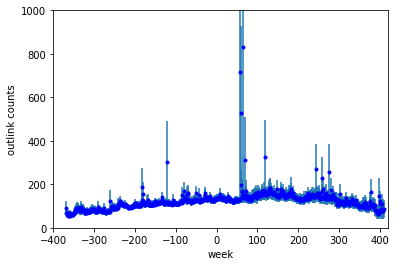

In [1328]:
#group data by week number
df_s_w_naw.info()
g=df_s_w_naw.groupby("week")

b_w_st_dict=defaultdict()

for week_name,series in g:
    b_w_st_dict[week_name]={"mean_w":series.views.mean(),"std_1":series.views.sem(),
                            "count":series[~series.views.isnull()].views.count()}
#create df
df_s_w_st_naw=pd.DataFrame.from_dict(b_w_st_dict,orient="index")
print len(df_s_w_st_naw)
df_s_w_st_naw=df_s_w_st_naw[df_s_w_st_naw["count"]>10]
print len(df_s_w_st_naw)
df_s_w_st_naw.info()


plt.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,linestyle='None')
plt.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,".b",linewidth = 1)
plt.xlim(-400,420)
plt.ylim(0,1000)
plt.xlabel("week")
plt.ylabel("outlink counts");

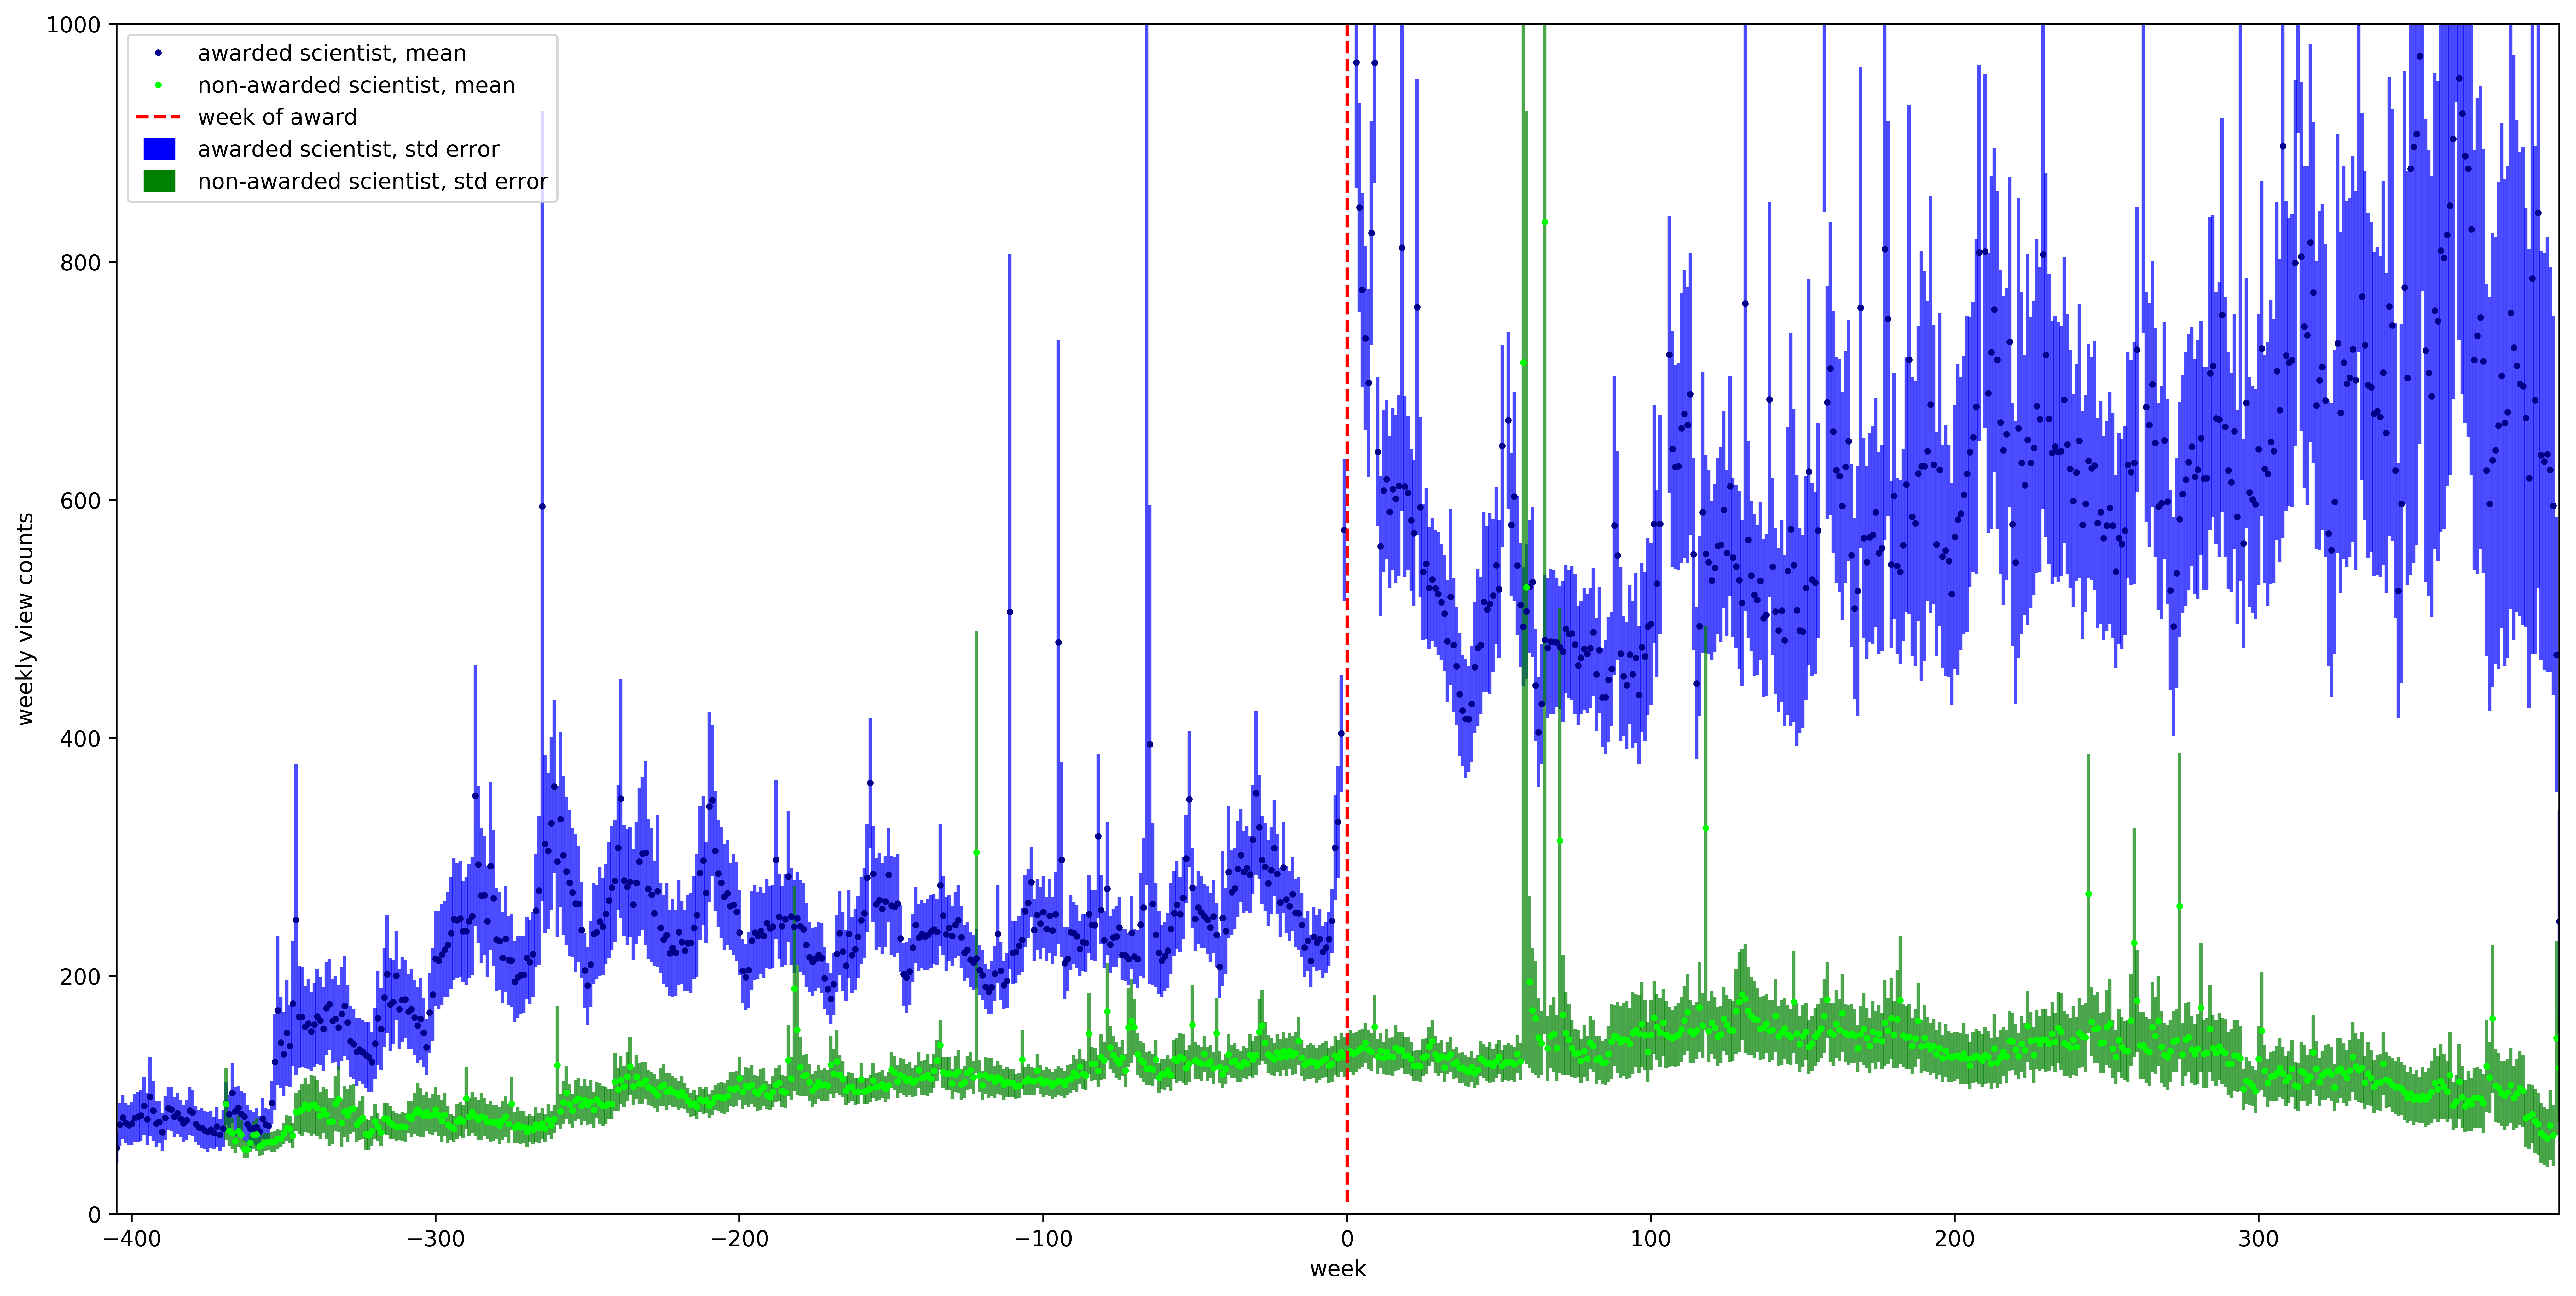

In [1329]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[20,10],dpi=500)

ax0.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,".",c="darkblue",linewidth = 1,ms=4,label="awarded scientist, mean")
ax0.set_xlim(df_s_w_st_aw.iloc[0].name,df_s_w_st_aw.iloc[-1].name)
ax0.set_ylim(0,1000)
ax0.set_xlabel("week")
ax0.set_ylabel("weekly view counts")


ax0.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,".",c="lime",linewidth = 1,ms=4,label="non-awarded scientist, mean")
ax0.plot([0,0],[10,10000],"r--",label="week of award")
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

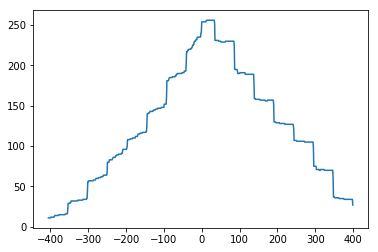

In [1331]:
df_s_w_st_aw["count"].plot()

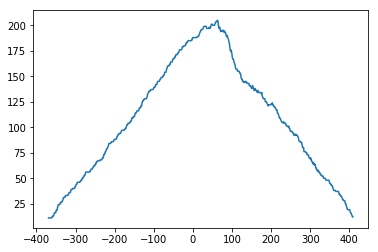

In [1332]:
df_s_w_st_naw["count"].plot()

In [1253]:
#print df_s_w_naw[df_s_w_naw.views.isnull()].article.unique()
print df_s_w_naw [df_s_w_naw.article=="Axel_D._Becke"]["views"]
#print df_s_w_naw[df_s_w_naw.views.isnull()&(df_s_w_naw.all_topics_len!=0.0)].article.unique()

 0      38.0
 1      62.0
 2     181.0
 3      59.0
 4      49.0
 5      53.0
 6      54.0
 7      57.0
 8      57.0
 9      42.0
 10     82.0
 11     63.0
 12     54.0
 13     51.0
 14     54.0
 15     30.0
 16     30.0
 17     52.0
 18     51.0
 19     40.0
 20     54.0
 21     68.0
 22     60.0
 23     61.0
 24     58.0
 25     43.0
 26     56.0
 27     41.0
 28     45.0
 29     60.0
       ...  
-30     50.0
-29     51.0
-28     28.0
-27     55.0
-26     61.0
-25     49.0
-24     38.0
-23     30.0
-22     38.0
-21     34.0
-20     39.0
-19     40.0
-18     33.0
-17     48.0
-16     30.0
-15     41.0
-14     42.0
-13     45.0
-12     41.0
-11     46.0
-10     31.0
-9      33.0
-8      53.0
-7      49.0
-6      37.0
-5      42.0
-4      36.0
-3      39.0
-2      31.0
-1      46.0
Name: views, Length: 448, dtype: float64


In [1267]:
gg_temp=df_s_w_naw.groupby("article")
for art,s_art in gg_temp:
    if s_art["views"].isnull().all():
        print art

# Scientific topics

## about awarded scientists

In [405]:
def read_topic_txt(filename,topic_dir):
    topic_df=pd.DataFrame.from_csv(filename,sep="\t",index_col=None,header=None).rename(columns={0:"topic"})
    attention_dict = {}
    for topic in topic_df.topic.values:
        time_list=[]
        txtname = os.path.join(topic_dir + '\\' + topic + '.txt') 
        try:
            f = open(txtname)
            temp_time_list=[]
            for line in f:
                temp_time_list = map(int, line.split(','))[1:]
                time_list.extend(temp_time_list)
            len_time_list=len(time_list)
            #print len_time_list
            if len_time_list<3074:
                temp=[np.nan]*(3074-len(time_list))
                temp.extend(time_list)
                time_list=temp
            f.close()
            attention_dict.update({topic:time_list})
        except IOError:
            print txtname
            continue
    return attention_dict


seed_topic = read_topic_txt('data\\seed_topics_list.txt',"data\\topics_views")

data\topics_views\Chandy-Lamport_algorithm.txt
data\topics_views\N-group_(finite_group_theory).txt
data\topics_views\Quasi-maximum_likelihood_estimate.txt
data\topics_views\MM.txt
data\topics_views\Teichm%C3%BCller_space.txt
data\topics_views\%C3%85ngstr%C3%B6m.txt
data\topics_views\Journal_officiel_de_la_R%C3%A9publique_fran%C3%A7aise.txt
data\topics_views\Ng%C3%B4.txt
data\topics_views\N%C3%A9ron%E2%80%93Tate_height.txt
data\topics_views\Gromov%27s_inequality_for_complex_projective_space.txt
data\topics_views\Crossing_number_inequality.txt
data\topics_views\J%C3%A1nos_Bolyai_Mathematical_Society.txt
data\topics_views\P%C3%B3lya_conjecture.txt
data\topics_views\Rank_of_an_elliptic_curve.txt
data\topics_views\neu.txt
data\topics_views\Theta_wave.txt


In [410]:
df_s_topic=pd.DataFrame.from_dict(seed_topic)
#df_s_topic.describe()
print df_s_topic.count()

df_s_topic.set_index(pd.DatetimeIndex(start=datetime(2008,1,1),freq="D",periods=3074),inplace=True)
df_s_topic=df_s_topic.resample('W').sum()
df_s_topic=df_s_topic.T

%C3%89tale_cohomology                              3074
%CE%94-hyperbolic_space                            3074
(B,_N)_pair                                        3074
1,000,000,000                                      3074
1,2,3-Triazole                                     3074
15_and_290_theorems                                3074
1851_Research_Fellowship                           3074
30S                                                3074
3G                                                 3074
4Pi_microscope                                     3074
50S                                                3074
50_Most_Influential_(Bloomberg_Markets_ranking)    1613
51_Pegasi                                          3074
51_Pegasi_b                                        3074
55_Cancri_d                                        3074
55_Cancri_e                                        3074
ATP-sensitive_potassium_channel                    3074
A_Brief_History_of_Time_(film)                  

In [412]:
df_s_topic.head()

2008-01-06  2008-01-13  2008-01-20  2008-01-27  \
%C3%89tale_cohomology         154.0       207.0       196.0       175.0   
%CE%94-hyperbolic_space        17.0        37.0        23.0        43.0   
(B,_N)_pair                    45.0        74.0        71.0        71.0   
1,000,000,000                3658.0      5673.0      6106.0      6462.0   
1,2,3-Triazole                 85.0       130.0       148.0       121.0   

                         2008-02-03  2008-02-10  2008-02-17  2008-02-24  \
%C3%89tale_cohomology         227.0       193.0       234.0       186.0   
%CE%94-hyperbolic_space        40.0        44.0        27.0        28.0   
(B,_N)_pair                    57.0        66.0        73.0        49.0   
1,000,000,000                6221.0      6194.0      7167.0      7681.0   
1,2,3-Triazole                163.0       142.0       145.0       148.0   

                         2008-03-02  2008-03-09     ...      2016-04-03  \
%C3%89tale_cohomology         200.0       225.0     ...           231.0   
%CE%94-hyperbolic_space        44.0        26.0     ...            38.0   
(B,_N)_pair                    71.0        99.0     ...            46.0   
1,000,000,000                6892.0      7970.0     ...          7526.0   
1,2,3-Triazole                177.0       187.0     ...           250.0   

                         2016-04-10  2016-04-17  2016-04-24  2016-05-01  \
%C3%89tale_cohomology         190.0       240.0       219.0       184.0   
%CE%94-hyperbolic_space        74.0        72.0        61.0        71.0   
(B,_N)_pair                    60.0        48.0        31.0        46.0   
1,000,000,000                7864.0      7570.0      7668.0      7537.0   
1,2,3-Triazole                268.0       227.0       273.0       254.0   

                         2016-05-08  2016-05-15  2016-05-22  2016-05-29  \
%C3%89tale_cohomology         180.0       290.0       286.0       227.0   
%CE%94-hyperbolic_space        45.0        67.0        64.0        52.0   
(B,_N)_pair                    60.0        55.0        57.0        45.0   
1,000,000,000                7105.0      7104.0      7104.0      6670.0   
1,2,3-Triazole                221.0       250.0       235.0       205.0   

                         2016-06-05  
%C3%89tale_cohomology          48.0  
%CE%94-hyperbolic_space        21.0  
(B,_N)_pair                    14.0  
1,000,000,000                2029.0  
1,2,3-Triazole                 93.0  

[5 rows x 440 columns]

# plot topics



#remove views according to creation date

### clean datasets

In [869]:
with open("data/seed_topic_creation_date.json","r") as f:
    topic_aw_dict=json.load(f,encoding="utf-8")
df_aw_topic=pd.DataFrame.from_dict(topic_aw_dict,orient="index").rename(columns={0:"Page_created"})
#print df_aw_topic
print df_aw_topic[df_aw_topic.index.str.contains("space")]
df_aw_topic.Page_created=pd.to_datetime(df_aw_topic.Page_created)
df_aw_topic.Page_created=df_aw_topic.Page_created.apply(lambda x: x.date() )
df_aw_topic.set_index(df_aw_topic.index.str.replace(" ","_") ,inplace=True)

#print 
print df_aw_topic[df_aw_topic.index.str.contains("space")]

df_aw_topic["name_link"]=df_aw_topic.apply(lambda x: x.name.upper()[0]+ x.name[1:].split("#",1)[0].replace("_(number)",""),
                                           axis=1)
df_aw_topic.set_index(df_aw_topic["name_link"].str.encode("utf-8").values,inplace=True)
#df_aw_topic["name_link"]=df_aw_topic.apply(lambda x: urllib.quote(x.name), axis=1)
#df_aw_topic.set_index(df_aw_topic["name_link"].values,inplace=True)
df_aw_topic[df_aw_topic.index.str.contains(",000")].index

                                                          Page_created
spacetime                                         2001-11-04T06:31:26Z
Deligne–Mumford moduli space of curves            2010-02-20T09:42:22Z
phase space                                       2003-03-02T21:56:14Z
polar space                                       2006-02-03T20:34:33Z
rigid analytic space                              2006-07-04T18:05:57Z
δ-hyperbolic space                                2004-12-16T15:00:34Z
Euclidean space                                   2001-08-27T19:16:37Z
Minkowski space                                   2003-05-20T13:28:35Z
Seven-dimensional space                           2009-12-24T14:44:20Z
Teichmüller space                                 2005-05-03T19:04:56Z
Gromov's inequality for complex projective space  2007-07-01T14:25:54Z
moduli space                                      2003-11-09T19:56:19Z
                                                 Page_created
spacetime      

Index([u'1,000,000,000'], dtype='object')

In [870]:
df_s_topic["name_link"]=df_s_topic.apply(lambda x: urllib.unquote(x.name),axis=1 )
df_s_topic.set_index(df_s_topic["name_link"].values,inplace=True)
df_s_topic.drop(columns="name_link",inplace=True)

print len(df_aw_topic)
print len(df_s_topic)
df_s_topic.drop_duplicates(inplace=True)
print len(df_s_topic)
df_aw_topic.drop_duplicates(inplace=True) 
print len(df_aw_topic)

# df_s_topic change change  R__rule_(ecology)  to R*_rule_(ecology)

2351
1895
1895
2173


In [839]:
import wikipedia


df_new=df_s_topic.join(df_aw_topic, how='outer')#.index.values# inner-> 1506, left - 1895 rows
#df_new[(df_new.name_link.isnull() )| (df_new.iloc[:,425].isnull() )]



list_names= df_new[(df_new.iloc[:,425].isnull() )].index.values 
redir_duict=defaultdict() 
for wiki_link in list_names:
    try:
        wiki_p = wikipedia.page(wiki_link,auto_suggest=False)
        redir_duict[wiki_link]=wiki_p.title
    except (KeyboardInterrupt, SystemExit):
        raise
    except wikipedia.exceptions.DisambiguationError as e:
        print wiki_link
        print e.options
    except:
        print wiki_link

MD_
[u'Main droite', u'MiniDisc', u'Music director', u'MDs (TV series)', u"Materiali e discussioni per l'analisi dei testi classici", u'Mega Drive', u'McDonnell Douglas', u'Air Madagascar', u'Maryland', u'Moldova', u'Magdeburg', u'metropolitan statistical area', u'Doctor of Medicine', u'Muscular dystrophy', u'Medial dorsal nucleus', u'.md', u'mkdir', u'Markdown', u'Message-digest algorithm', u'Microdrive', u'mdadm', u'Mean absolute difference', u'Mendelevium', u'Storm Prediction Center', u'Methyldichloroarsine', u'Millidarcy', u'Molecular dynamics', u'Managing director', u'Majority decision', u'Man-day', u'Major Douglas', u'Unicode subscripts and superscripts', u'Muhammad (name)', u'1500', u'Medium (disambiguation)']
R_rule_(ecology)


In [854]:
redir_duict['MD_']='MD'
redir_duict['R_rule_(ecology)']='R__rule_(ecology)'
redir_duict['1,000,000,000_(number)']='1,000,000,000'

redir_duict2=defaultdict()
for k,v in redir_duict.iteritems():
    redir_duict2[k]=v.replace(" ","_").encode("utf-8")
    
df_aw_topic["name_link"]=df_aw_topic.apply(lambda x:  redir_duict2[x.name]if x.name in list_names else x.name ,axis=1)
df_aw_topic.set_index(df_aw_topic["name_link"].values,inplace=True)
df_aw_topic.drop_duplicates(["name_link"],inplace=True)   

In [902]:
df_new=df_s_topic.join(df_aw_topic, how='outer')# inner1877 #left 1895
#df_new[(df_new.name_link.isnull() )]
list_names2= df_new[(df_new.name_link.isnull() )].index.values 

for wiki_link in list_names2:
    try:
        wiki_p = wikipedia.page(wiki_link,auto_suggest=False)
        redir_duict[wiki_link]=wiki_p.title
    except (KeyboardInterrupt, SystemExit):
        raise
    except wikipedia.exceptions.DisambiguationError as e:
        print wiki_link
        print e.options
    except:
        print wiki_link

List_of_minor_planets_3001–4000
List_of_minor_planets_48001–49000
List_of_minor_planets_5001–6000


In [911]:
redir_duict['List_of_minor_planets_3001–4000']='List_of_minor_planets:_3001–4000'
redir_duict['List_of_minor_planets_48001–49000']='List_of_minor_planets:_48001–49000'
redir_duict['List_of_minor_planets_5001–6000']='List_of_minor_planets:_5001–6000'

redir_duict2=defaultdict()
for k,v in redir_duict.iteritems():
    redir_duict2[k]=v.replace(" ","_").encode("utf-8")
       
df_s_topic["name_link"]=df_s_topic.apply(lambda x:  redir_duict2[x.name]if x.name in list_names2 else x.name ,axis=1)
df_s_topic.set_index(df_s_topic["name_link"].values,inplace=True)
df_s_topic.drop(columns="name_link",inplace=True)
 
df_s_topic[df_s_topic.duplicated()]

Empty DataFrame
Columns: [2008-01-06 00:00:00, 2008-01-13 00:00:00, 2008-01-20 00:00:00, 2008-01-27 00:00:00, 2008-02-03 00:00:00, 2008-02-10 00:00:00, 2008-02-17 00:00:00, 2008-02-24 00:00:00, 2008-03-02 00:00:00, 2008-03-09 00:00:00, 2008-03-16 00:00:00, 2008-03-23 00:00:00, 2008-03-30 00:00:00, 2008-04-06 00:00:00, 2008-04-13 00:00:00, 2008-04-20 00:00:00, 2008-04-27 00:00:00, 2008-05-04 00:00:00, 2008-05-11 00:00:00, 2008-05-18 00:00:00, 2008-05-25 00:00:00, 2008-06-01 00:00:00, 2008-06-08 00:00:00, 2008-06-15 00:00:00, 2008-06-22 00:00:00, 2008-06-29 00:00:00, 2008-07-06 00:00:00, 2008-07-13 00:00:00, 2008-07-20 00:00:00, 2008-07-27 00:00:00, 2008-08-03 00:00:00, 2008-08-10 00:00:00, 2008-08-17 00:00:00, 2008-08-24 00:00:00, 2008-08-31 00:00:00, 2008-09-07 00:00:00, 2008-09-14 00:00:00, 2008-09-21 00:00:00, 2008-09-28 00:00:00, 2008-10-05 00:00:00, 2008-10-12 00:00:00, 2008-10-19 00:00:00, 2008-10-26 00:00:00, 2008-11-02 00:00:00, 2008-11-09 00:00:00, 2008-11-16 00:00:00, 2008-11-23 00:00:00, 2008-11-30 00:00:00, 2008-12-07 00:00:00, 2008-12-14 00:00:00, 2008-12-21 00:00:00, 2008-12-28 00:00:00, 2009-01-04 00:00:00, 2009-01-11 00:00:00, 2009-01-18 00:00:00, 2009-01-25 00:00:00, 2009-02-01 00:00:00, 2009-02-08 00:00:00, 2009-02-15 00:00:00, 2009-02-22 00:00:00, 2009-03-01 00:00:00, 2009-03-08 00:00:00, 2009-03-15 00:00:00, 2009-03-22 00:00:00, 2009-03-29 00:00:00, 2009-04-05 00:00:00, 2009-04-12 00:00:00, 2009-04-19 00:00:00, 2009-04-26 00:00:00, 2009-05-03 00:00:00, 2009-05-10 00:00:00, 2009-05-17 00:00:00, 2009-05-24 00:00:00, 2009-05-31 00:00:00, 2009-06-07 00:00:00, 2009-06-14 00:00:00, 2009-06-21 00:00:00, 2009-06-28 00:00:00, 2009-07-05 00:00:00, 2009-07-12 00:00:00, 2009-07-19 00:00:00, 2009-07-26 00:00:00, 2009-08-02 00:00:00, 2009-08-09 00:00:00, 2009-08-16 00:00:00, 2009-08-23 00:00:00, 2009-08-30 00:00:00, 2009-09-06 00:00:00, 2009-09-13 00:00:00, 2009-09-20 00:00:00, 2009-09-27 00:00:00, 2009-10-04 00:00:00, 2009-10-11 00:00:00, 2009-10-18 00:00:00, 2009-10-25 00:00:00, 2009-11-01 00:00:00, 2009-11-08 00:00:00, 2009-11-15 00:00:00, 2009-11-22 00:00:00, 2009-11-29 00:00:00, ...]
Index: []

[0 rows x 440 columns]

In [1122]:
df_new=df_s_topic.join(df_aw_topic, how='left')
print df_new[(df_new.name_link.isnull()) ].index
df_new=df_s_topic.join(df_aw_topic, how='outer')
#df_new[(df_new.name_link.isnull() ) |(df_new.iloc[:,425].isnull())]

Index([u'Classified_information', u'German_diaspora', u'Hard_and_soft_science',
       u'Invention', u'Logic', u'Mechanism_design'],
      dtype='object')


In [925]:
df_new=df_s_topic.join(df_aw_topic, how='inner')
df_new

2008-01-06 00:00:00  \
Étale_cohomology                                               154.0   
Δ-hyperbolic_space                                              17.0   
(B,_N)_pair                                                     45.0   
1,000,000,000                                                 3658.0   
1,2,3-Triazole                                                  85.0   
15_and_290_theorems                                            171.0   
1851_Research_Fellowship                                        42.0   
30S                                                            161.0   
3G                                                           19292.0   
4Pi_microscope                                                  38.0   
50S                                                            132.0   
50_Most_Influential_(Bloomberg_Markets_ranking)                  NaN   
51_Pegasi                                                      330.0   
51_Pegasi_b                                                    327.0   
55_Cancri_d                                                     64.0   
55_Cancri_e                                                     78.0   
ATP-sensitive_potassium_channel                                 64.0   
A_Brief_History_of_Time_(film)                                 480.0   
Abelian_group                                                  969.0   
Abelian_variety                                                155.0   
Abiogenesis                                                   8119.0   
Abortion-rights_movements                                       14.0   
Absolute_zero                                                 7793.0   
Abstraction_(software_engineering)                               NaN   
Academic_boycott_of_Israel                                       NaN   
Accelerating_expansion_of_the_universe                           NaN   
Accounting                                                       NaN   
Acetylation                                                    985.0   
Action_potential                                              3941.0   
Activator_(genetics)                                           194.0   
...                                                              ...   
Well-being                                                     366.0   
Western_clawed_frog                                             68.0   
Weyl_curvature_hypothesis                                       62.0   
Weyl_tensor                                                    106.0   
Wheeler–DeWitt_equation                                        174.0   
White_dwarf                                                   4246.0   
White_test                                                     237.0   
Wild_type                                                      414.0   
Wobble_base_pair                                               472.0   
Woodrow_Wilson_Awards                                           27.0   
Workforce                                                      734.0   
Workforce_productivity                                         204.0   
World_Bank_Chief_Economist                                      95.0   
Wuxia                                                         4572.0   
X-ray                                                        11231.0   
X-ray_crystallography                                         4068.0   
X.25                                                          1503.0   
Xenopus                                                        628.0   
Xerox_Alto                                                     856.0   
Yablonovite                                                      0.0   
Yeast                                                        13733.0   
Yeast_artificial_chromosome                                    328.0   
Yield_curve                                                   4287.0   
Yrjö_Jahnsson_Foundation                                         0.0   
Zariski's_main_th

In [1398]:
df_new.index.values

array(['(B,_N)_pair', '1,000,000,000', '1,2,3-Triazole', ...,
       '\xc3\x85ngstr\xc3\xb6m', '\xc3\x89tale_cohomology',
       '\xce\x94-hyperbolic_space'], dtype=object)

### assign scientists to each topic

In [940]:
with open("data/seed_neighbors_list_clean_en.json","r") as f:
    sc_topic_aw=json.load(f,encoding="utf-8")
sc_topic_aw2={}
for k,v in sc_topic_aw.iteritems():
    k=k.rstrip().split('/')[-1]
    sc_topic_aw2[k]=[ urllib.quote_plus(i.replace(" ","_").encode('utf8')) for i in v]
    
#clean topics which are corresponds to scientists 
sc_topic_aw3=defaultdict()
for article_name in sc_topic_aw2:
    #print article_name
    temp_list=[ urllib.unquote( i.upper()[0]+ i[1:].split('%23')[0] )   for i in sc_topic_aw2[article_name]]
    temp_list=[redir_duict2[i] if i in redir_duict2.keys() else i for i in temp_list ]
    sc_topic_aw3[article_name]=list(set(temp_list))
    
    
#remove views which corresponds to dates with no article exist
df_s_topic_new=df_new.apply(lambda x:[ i if type(j)==str else i if j.date() >= x["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)
df_s_topic_new.describe()    
df_s_topic_new.columns =df_s_topic_new.columns.map(lambda x:  x if type(x)==str else x.date())

2008-01-06     2008-01-13     2008-01-20     2008-01-27  \
count    1544.000000    1545.000000    1546.000000    1546.000000   
mean     3341.698834    5221.070550    5534.751617    5552.344114   
std      6881.485242   10101.733925   10230.869841   10303.660695   
min         0.000000       0.000000       0.000000       0.000000   
25%       187.000000     288.000000     319.750000     303.250000   
50%       899.500000    1405.000000    1520.500000    1520.000000   
75%      3561.250000    5709.000000    6158.750000    6166.500000   
max    102457.000000  130226.000000  109876.000000  108827.000000   

          2008-02-03    2008-02-10    2008-02-17    2008-02-24    2008-03-02  \
count    1548.000000   1551.000000   1553.000000   1554.000000   1556.000000   
mean     5673.437984   5620.317859   5593.889891   5759.082368   6028.967224   
std     10733.325305  10268.810723   9993.571049  10281.631329  10821.699772   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%       314.000000    310.000000    321.000000    339.500000    333.750000   
50%      1525.500000   1528.000000   1549.000000   1613.500000   1665.500000   
75%      6259.500000   6256.500000   6237.000000   6316.750000   6694.750000   
max    118488.000000  96905.000000  87758.000000  91518.000000  99414.000000   

          2008-03-09      ...         2016-04-03    2016-04-10    2016-04-17  \
count    1556.000000      ...        1888.000000   1888.000000   1888.000000   
mean     5937.101542      ...        2991.447564   3151.146716   3217.107521   
std     10886.525401      ...        4419.342926   4593.078431   4792.282226   
min         0.000000      ...           1.000000      1.000000      3.000000   
25%       330.750000      ...         329.750000    344.500000    350.500000   
50%      1629.500000      ...        1308.000000   1376.000000   1376.500000   
75%      6613.000000      ...        3860.000000   4088.250000   4092.250000   
max    130555.000000      ...       48603.000000  50710.000000  56095.000000   

         2016-04-24    2016-05-01    2016-05-08    2016-05-15    2016-05-22  \
count   1889.000000   1889.000000   1889.000000   1889.000000   1889.000000   
mean    3211.326098   3205.806247   3089.198518   3046.137110   2998.338804   
std     4719.722779   4803.016941   4483.781800   4498.623518   4414.248251   
min        2.000000      3.000000      2.000000      3.000000      2.000000   
25%      369.000000    359.000000    355.000000    341.000000    336.000000   
50%     1411.000000   1392.000000   1356.000000   1315.000000   1264.000000   
75%     4198.000000   4153.000000   4075.000000   3927.000000   3908.000000   
max    51940.000000  50880.000000  47791.000000  50404.000000  43350.000000   

         2016-05-29    2016-06-05  
count   1889.000000   1889.000000  
mean    2844.348332    844.543674  
std     4160.201229   1411.138196  
min        1.000000      0.000000  
25%      310.000000     94.000000  
50%     1221.000000    370.000000  
75%     3693.000000   1123.000000  
max    39976.000000  34043.000000  

[8 rows x 440 columns]

In [1367]:
def views_topic_mean_count(x,df_topics,sc_topic):#df_s_topic_new
    topic_list=sc_topic[x.article] #sc_topic_aw3
    topic_list_len=len(topic_list)
    #print x.time_w , x.article, x.week, topic_list_len
    if topic_list_len==0:
        return pd.Series([0, 0, None, None,[]])
    else:
        if x.time_w<datetime(2008,1,6).date():
            return pd.Series([topic_list_len, None, None, None, []])
        else:
            df_temp=df_topics[df_topics.index.isin(topic_list)][x.time_w]
            #print df_temp.mean(), df_temp.sem()
            #if topic_list_len!=len(df_temp):
            #    print df_temp.values
            #    print np.sort(topic_list)
            return pd.Series([topic_list_len, len(df_temp), df_temp.mean(), df_temp.sem(), df_temp.dropna().values])

In [1368]:

df_s_w_aw[['all_topics_len','topics_at_time','views_mean',"views_sem","views_list"]]= df_s_w_aw.apply(lambda x: views_topic_mean_count(x,df_s_topic_new,sc_topic_aw3), axis=1)

In [1431]:
df_s_w_aw.head()

time_w    views     article week  all_topics_len  topics_at_time  \
0  2009-10-11  37120.0  Ada_Yonath    0              18              18   
1  2009-10-18   5675.0  Ada_Yonath    1              18              18   
2  2009-10-25   2069.0  Ada_Yonath    2              18              18   
3  2009-11-01   1609.0  Ada_Yonath    3              18              18   
4  2009-11-08   1531.0  Ada_Yonath    4              18              18   

     views_mean    views_sem  \
0  16106.285714  4652.084900   
1  14767.642857  4297.524972   
2  14858.214286  4296.598780   
3  13620.785714  3878.331512   
4  15597.928571  4407.080207   

                                          views_list  
0  [15331.0, 16773.0, 33216.0, 21558.0, 198.0, 46...  
1  [13882.0, 16239.0, 31552.0, 20505.0, 77.0, 408...  
2  [13177.0, 15747.0, 33736.0, 20422.0, 58.0, 396...  
3  [13003.0, 14876.0, 28081.0, 18957.0, 33.0, 370...  
4  [17099.0, 16624.0, 32107.0, 19647.0, 32.0, 387...

In [1370]:
df_s_w_aw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115280 entries, 0 to -1
Data columns (total 9 columns):
time_w            115280 non-null object
views             99357 non-null float64
article           115280 non-null object
week              115280 non-null object
all_topics_len    115280 non-null int64
topics_at_time    115280 non-null int64
views_mean        112164 non-null float64
views_sem         107342 non-null float64
views_list        115280 non-null object
dtypes: float64(3), int64(2), object(4)
memory usage: 11.3+ MB


In [1276]:
print df_s_w_aw[df_s_w_aw.views_mean.isnull()&(df_s_w_aw.all_topics_len==0.0)].article.unique()
print df_s_w_aw[df_s_w_aw.views_mean.isnull()&(df_s_w_aw.all_topics_len!=0.0)].article.unique()
print sc_topic_aw3[u'Charles_Lee_(scientist)']
print sc_topic_aw3[u'Graham_Hutchings']
print sc_topic_aw3[u'Peter_Crane']
print sc_topic_aw3[u'Ramamoorthy_Ramesh']
print sc_topic_aw3[u'Winslow_Briggs']
print sc_topic_aw3[u'Yoshinori_Ohsumi']
print "\n"
print sc_topic_aw3[u'Graeme_Moad'] 
print sc_topic_aw3[u'Stephen_W._Scherer'] 

[u'Charles_Lee_(scientist)' u'Graham_Hutchings' u'Peter_Crane'
 u'Ramamoorthy_Ramesh' u'Winslow_Briggs' u'Yoshinori_Ohsumi']
[u'Graeme_Moad' u'Stephen_W._Scherer']
[]
[]
[]
[]
[]
[]


['Polymer_chemistry']
['Genome_Canada', 'Quirks_&_Quarks']


834
805
<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, -405 to 399
Data columns (total 5 columns):
count         805 non-null int64
count_all     805 non-null int64
mean_w        805 non-null float64
mean_w_all    805 non-null float64
std_1         805 non-null float64
dtypes: float64(3), int64(2)
memory usage: 37.7 KB


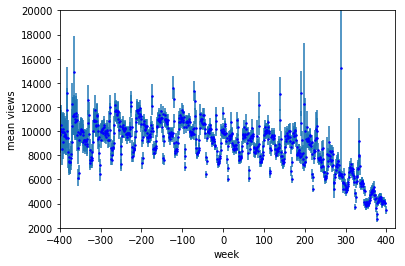

In [1392]:
#group data by week number

g=df_s_w_aw.groupby("week")
s_w_st_dict_topic=defaultdict()
for week_name,series in g:
    concatenated = []
    for l in series.views_list.values:
        concatenated.extend(l) 
    #print concatenated
    s_w_st_dict_topic[week_name]={"mean_w":series.views_mean.mean(), "std_1":series.views_mean.sem(),
                           "count":series[~series.views_mean.isnull()].views_mean.count(),
                                "mean_w_all":np.mean(list(set(concatenated))),"count_all": len(set(concatenated)) }

df_s_w_st_topic=pd.DataFrame.from_dict(s_w_st_dict_topic,orient="index")
print len(df_s_w_st_topic)
df_s_w_st_topic=df_s_w_st_topic[df_s_w_st_topic["count"]>10]
print len(df_s_w_st_topic)
df_s_w_st_topic.info()


plt.errorbar(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w, df_s_w_st_topic.std_1,linestyle='None')
plt.plot(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w,".b",linewidth = 1,ms=3)
plt.xlim(-400,420)
plt.ylim(2000,20000)
plt.xlabel("week")
plt.ylabel("mean views");

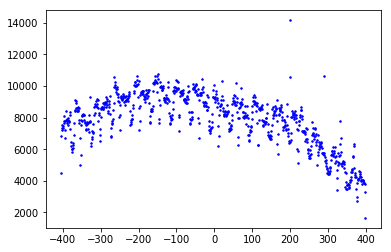

In [1393]:
#plt.errorbar(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w_all, df_s_w_st_topic.std_1,linestyle='None')
plt.plot(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w_all,".b",linewidth = 1,ms=3)

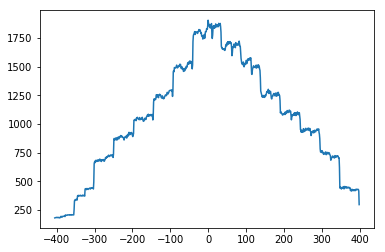

In [1394]:
df_s_w_st_topic.count_all.plot()

In [1350]:
df_s_w_aw[df_s_w_aw.week==-406]


time_w  views            article  week  all_topics_len  \
-406  2008-01-06    NaN  Charles_F._Manski  -406             8.0   
-406  2008-01-06   75.0       John_A._List  -406            19.0   
-406  2008-01-06   27.0   Richard_Blundell  -406             5.0   

      topics_at_time   views_mean    views_sem  
-406             8.0  4784.000000  3035.481087  
-406            19.0  4002.214286  1700.090228  
-406             5.0  2967.400000  1066.481392

## about non-awarded scientists

In [1068]:
base_topic = read_topic_txt('data\\baseline_topics_list.txt',"data\\topics_views")
df_b_topic=pd.DataFrame.from_dict(base_topic)
#df_s_topic.describe()
#print df_b_topic.count()

df_b_topic.set_index(pd.DatetimeIndex(start=datetime(2008,1,1),freq="D",periods=3074),inplace=True)
df_b_topic=df_b_topic.resample('W').sum()
df_b_topic=df_b_topic.T

df_b_topic["name_link"]=df_b_topic.apply(lambda x: urllib.unquote(x.name),axis=1 )
df_b_topic.set_index(df_b_topic["name_link"].values,inplace=True)
df_b_topic.drop(columns="name_link",inplace=True)

data\topics_views\Carbon%E2%80%93hydrogen_bond_activation.txt
data\topics_views\Ease_of_doing_business_index.txt


In [1065]:
with open("data/baseline_topic_creation_date.json","r") as f:
    topic_naw_dict=json.load(f,encoding="utf-8")
df_naw_topic=pd.DataFrame.from_dict(topic_naw_dict,orient="index").rename(columns={0:"Page_created"})
#df_aw_topic
df_naw_topic.Page_created=pd.to_datetime(df_naw_topic.Page_created)
df_naw_topic.Page_created=df_naw_topic.Page_created.apply(lambda x: x.date() )
df_naw_topic.set_index(df_naw_topic.index.str.replace(" ","_") ,inplace=True)
 
print df_naw_topic[df_naw_topic.index.str.contains("#")]["Page_created"]

df_naw_topic["name_link"]=df_naw_topic.apply(lambda x: x.name.upper()[0]+ x.name[1:].split("#",1)[0],axis=1)
df_naw_topic.set_index(df_naw_topic["name_link"].str.encode("utf-8").values,inplace=True)
#list(np.sort(list(df_naw_topic["name_link"].values)))[:20]
#df_naw_topic[df_naw_topic.index.str.contains("pace")]

Motivation#Intrinsic_and_extrinsic_motivation              2003-05-23
Photodissociation#Quantum_models                           2005-11-22
Government_of_Bulgaria#Structure_of_the_Current_Cabinet    2006-08-10
Spin_glass#The_model_of_Sherrington_and_Kirkpatrick        2002-11-18
Name: Page_created, dtype: object


Page_created                     name_link
Cardiac_pacemaker              2003-05-25             Cardiac_pacemaker
Space-time_code                2006-04-04               Space-time_code
Cardiac_pacemaker              2003-05-25             Cardiac_pacemaker
Gromov_hyperbolic_space        2007-08-28       Gromov_hyperbolic_space
Frame_of_a_vector_space        2015-08-10       Frame_of_a_vector_space
Artificial_cardiac_pacemaker   2002-09-05  Artificial_cardiac_pacemaker

In [1083]:
print len(df_naw_topic)
print len(df_b_topic)

df_b_topic.drop_duplicates(inplace=True)
print len(df_b_topic)

df_naw_topic.drop_duplicates(inplace=True) 
print len(df_naw_topic)

1306
1068
1068
1198


In [1096]:
df_new_b=df_b_topic.join(df_naw_topic, how='outer') # inner 853 #left  1068 
list_names3= df_new_b[(df_new_b.iloc[:,425].isnull() )].index.values 
#computing
for wiki_link in list_names3:
    try:
        wiki_p = wikipedia.page(wiki_link,auto_suggest=False)
        redir_duict[wiki_link]=wiki_p.title
    except (KeyboardInterrupt, SystemExit):
        raise
    except wikipedia.exceptions.DisambiguationError as e:
        print wiki_link
        print e.options
    except:
        print wiki_link

Adaptor_proteins
[u'Signal transducing adaptor protein', u'Vesicular transport adaptor protein', u'Clathrin adaptor protein']
Doug_Green
[u'Doug Green (footballer)', u'Doug Green (Louisiana politician)', u'Doug Green (Ohio politician)', u'Douglas B. Green', u'Douglas R. Green', u'Douglas Green (cricketer)', u'Doug Greenall']
Douglas_Green
[u'Doug Green (footballer)', u'Doug Green (Louisiana politician)', u'Doug Green (Ohio politician)', u'Douglas B. Green', u'Douglas R. Green', u'Douglas Green (cricketer)', u'Doug Greenall']
RAMP_hydrazone_alkylation_reaction


In [1099]:
redir_duict['Adaptor_proteins']='Adaptor_proteins'
#redir_duict['Doug_Green']='Doug_Green'
#redir_duict['Douglas_Green']='Doug_Green'
redir_duict['RAMP_hydrazone_alkylation_reaction']="Enders_SAMP/RAMP_hydrazone-alkylation_reaction"

for k,v in redir_duict.iteritems():
    redir_duict2[k]=v.replace(" ","_").encode("utf-8")
    
df_naw_topic["name_link"]=df_naw_topic.apply(lambda x:  redir_duict2[x.name] if (x.name in list_names3)&(x.name in redir_duict.keys())  else x.name ,axis=1)
df_naw_topic.set_index(df_naw_topic["name_link"].values,inplace=True)
df_naw_topic.drop_duplicates(["name_link"],inplace=True)   

In [1104]:
print len(df_b_topic)
print len(df_naw_topic)

1068
1075


In [1107]:
df_new_b=df_b_topic.join(df_naw_topic, how='outer')# inner 1057 #left 1068
list_names4= df_new_b[(df_new_b.name_link.isnull() )].index.values 
print len(list_names4)

for wiki_link in list_names4:
    try:
        wiki_p = wikipedia.page(wiki_link,auto_suggest=False)
        redir_duict[wiki_link]=wiki_p.title
    except (KeyboardInterrupt, SystemExit):
        raise
    except wikipedia.exceptions.DisambiguationError as e:
        print wiki_link
        print e.options
    except:
        print wiki_link

11
RAMP_hydrazone-alkylation_reaction


In [1111]:
redir_duict['RAMP_hydrazone-alkylation_reaction']="Enders_SAMP/RAMP_hydrazone-alkylation_reaction"

for k,v in redir_duict.iteritems():
    redir_duict2[k]=v.replace(" ","_").encode("utf-8")
       
df_b_topic["name_link"]=df_b_topic.apply(lambda x:  redir_duict2[x.name]if x.name in list_names4 else x.name ,axis=1)

df_b_topic.set_index(df_b_topic["name_link"].values,inplace=True)
df_b_topic.drop(columns="name_link",inplace=True)

In [1120]:
df_new_b=df_b_topic.join(df_naw_topic, how='inner') # 
#df_new_b[(df_new_b.name_link.isnull() ) |(df_new_b.iloc[:,425].isnull())]
#df_new_b[(df_new_b.name_link.isnull() ) | ()].index.values 

In [1121]:
df_new_b.head(3)

2008-01-06 00:00:00  2008-01-13 00:00:00  \
Hyperbolic_metric_space                 17.0                 37.0   
3-manifold                             344.0                468.0   
5G                                     191.0                181.0   

                         2008-01-20 00:00:00  2008-01-27 00:00:00  \
Hyperbolic_metric_space                 23.0                 43.0   
3-manifold                             525.0                459.0   
5G                                     225.0                170.0   

                         2008-02-03 00:00:00  2008-02-10 00:00:00  \
Hyperbolic_metric_space                 40.0                 44.0   
3-manifold                             495.0                489.0   
5G                                     199.0                266.0   

                         2008-02-17 00:00:00  2008-02-24 00:00:00  \
Hyperbolic_metric_space                 27.0                 28.0   
3-manifold                             415.0                500.0   
5G                                     268.0                201.0   

                         2008-03-02 00:00:00  2008-03-09 00:00:00  \
Hyperbolic_metric_space                 44.0                 26.0   
3-manifold                             474.0                431.0   
5G                                     228.0                206.0   

                                  ...             2016-04-17 00:00:00  \
Hyperbolic_metric_space           ...                            72.0   
3-manifold                        ...                           460.0   
5G                                ...                          7949.0   

                         2016-04-24 00:00:00  2016-05-01 00:00:00  \
Hyperbolic_metric_space                 61.0                 71.0   
3-manifold                             476.0                412.0   
5G                                    8086.0               8412.0   

                         2016-05-08 00:00:00  2016-05-15 00:00:00  \
Hyperbolic_metric_space                 45.0                 67.0   
3-manifold                             389.0                445.0   
5G                                    7628.0               8929.0   

                         2016-05-22 00:00:00  2016-05-29 00:00:00  \
Hyperbolic_metric_space                 64.0                 52.0   
3-manifold                             543.0                470.0   
5G                                    8018.0               8145.0   

                         2016-06-05 00:00:00  Page_created  \
Hyperbolic_metric_space                 21.0    2007-08-28   
3-manifold                             124.0    2004-09-26   
5G                                    2711.0    2009-07-03   

                                       name_link  
Hyperbolic_metric_space  Hyperbolic_metric_space  
3-manifold                            3-manifold  
5G                                            5G  

[3 rows x 442 columns]

In [1124]:
#remove views which corresponds to dates with no article exist

df_b_topic_new=df_new_b.apply(lambda x:[ i if type(j)==str else i if j.date() >= x["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)
df_b_topic_new.describe()    
df_b_topic_new.columns =df_b_topic_new.columns.map(lambda x:  x if type(x)==str else x.date())

# Intersection of topics

In [1429]:
#translate
list_non_award_topics=[ redir_duict2[i] if i in redir_duict2.keys() else i for i in df_new_b.index.values ]
list_award_topics=[ redir_duict2[i] if i in redir_duict2.keys() else i for i in df_new.index.values ]

print "len of non-award scientific topics", len(set(list_non_award_topics))
print "len of awarded scientific topics", len(set(list_award_topics))
intersection_topic=set(list_non_award_topics).intersection(set(list_award_topics))
len_int=len(set(list_non_award_topics).intersection(set(list_award_topics)))
print "len of intersection", len_int
print float(len_int)/len(set(list_non_award_topics))
print float(len_int)/len(set(list_award_topics))

len of non-award scientific topics 1064
len of awarded scientific topics 1921
len of intersection 300
0.281954887218
0.156168662155


In [1430]:
intersection_topic

{'Adaptive_immune_system',
 'Alcohol',
 'Algebra',
 'Algorithm',
 'Angiogenesis',
 'Antibiotics',
 'Antibody',
 'Applied_physics',
 'Artificial_intelligence',
 'Astronomy',
 'Astrophysics',
 'Autoimmune_disease',
 'Autoimmunity',
 'Bacteria',
 'Battery_(electricity)',
 'Behavioral_economics',
 'Biochemistry',
 'Bioinorganic_chemistry',
 'Biological_engineering',
 'Biology',
 'Biomaterial',
 'Biomedical_engineering',
 'Biomolecule',
 'Biophysics',
 'Black_hole',
 'Blog',
 'Bone_marrow',
 'Bose\xe2\x80\x93Einstein_condensate',
 'Boson',
 'Bounded_rationality',
 'Caenorhabditis_elegans',
 'Cancer',
 'Carbon_nanotube',
 'Carbon\xe2\x80\x93carbon_bond',
 'Cardiovascular_disease',
 'Catalysis',
 'Causality',
 'Cellular_automaton',
 'Cellular_differentiation',
 'Chemical_engineering',
 'Chemical_physics',
 'Chemical_synthesis',
 'Chemical_vapor_deposition',
 'Chemistry',
 'Chromatin',
 'Clinical_research',
 'Cloning',
 'Cointegration',
 'Colorectal_cancer',
 'Colossal_magnetoresistance',
 'Co

In [1428]:
np.sort(list(set(list_award_topics)-set(list_non_award_topics)))

array(['(B,_N)_pair', '1,000,000,000', '1,2,3-Triazole', ...,
       'Zuse_Institute_Berlin', '\xc3\x85ngstr\xc3\xb6m',
       '\xc3\x89tale_cohomology'],
      dtype='|S63')

1064
1889


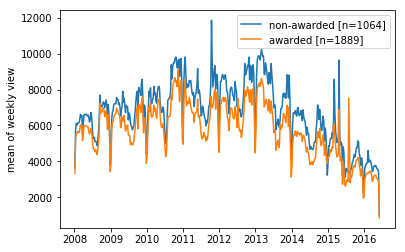

In [1466]:
print len(df_b_topic_new)
print len(df_s_topic_new)
df_b_topic_new.mean().plot(label="non-awarded [n=1064]")
df_s_topic_new.mean().plot(label="awarded [n=1889]")
plt.ylabel("mean of weekly view")
plt.legend()

765
1591


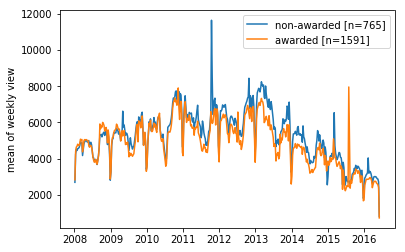

In [1465]:
print len(df_b_topic_new[~df_b_topic_new.index.isin(intersection_topic)])
print len(df_s_topic_new[~df_s_topic_new.index.isin(intersection_topic)])
df_b_topic_new[~df_b_topic_new.index.isin(intersection_topic)].mean().plot(label="non-awarded [n=765]")
df_s_topic_new[~df_s_topic_new.index.isin(intersection_topic)].mean().plot(label="awarded [n=1591]")
plt.ylabel("mean of weekly view")
plt.legend()

### assign topics to scientists

In [1126]:
with open("data/baseline_neighbors_list_clean_en.json","r") as f:
    sc_topic_naw=json.load(f,encoding="utf-8")
sc_topic_naw2={}
for k,v in sc_topic_naw.iteritems():
    k=k.rstrip().split('/')[-1]
    sc_topic_naw2[k]=[ urllib.quote_plus(i.replace(" ","_").encode('utf8')) for i in v]
    
#clean topics which are corresponds to scientists 
sc_topic_naw3=defaultdict()
for article_name in sc_topic_naw2:
    temp_list=[ urllib.unquote( i.upper()[0]+ i[1:].split('%23')[0] )   for i in sc_topic_naw2[article_name]]
    temp_list=[redir_duict2[i] if i in redir_duict2.keys() else i for i in temp_list ]
    sc_topic_naw3[article_name]=list(set(temp_list))

In [1194]:
dict_name={u'%C4%90%C3%A0m_Thanh_S%C6%A1n':"Dam_Thanh_Son",  u'%C5%BDeljko_Reiner':"Zeljko_Reiner",
 u'Achim_M%C3%BCller':"Achim_Muller",                u'Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si':"Albert-Laszlo_Barabasi",
 u'Andrew_H._Van_de_Ven':"Andrew_Van_de_Ven",        u'Axel_D._Becke':"Axel_Becke",
 u'Bengt_R._Holmstr%C3%B6m':"Bengt_Holmstrom",       u'Bruce_D._Walker':"Bruce_D_Walker",
 u'C._N._R._Rao':"C_N_R_Rao",                        u'Charles_M._Lieber':"Charles_Lieber",
 u'Chen_Guanrong':"Guanrong_Chen",                   u'Daron_Acemo%C4%9Flu':"Daron_Acemoglu",
 u'Dennis_P._Curran':"Dennis_Curran",                u'Edward_R._Dougherty':"Edward_R_Dougherty",
 u'Elias_James_Corey':"Elias_Corey",                 u'Fran%C3%A7ois_Diederich':"Francois_Diederich",
 u'G%C3%A1bor_A._Somorjai':"Gabor_Somorjai",         u'G%C3%A9rald_Bastard':"Gerald_Bastard",
 u'G%C3%A9rard_F%C3%A9rey':"Gerard_Ferey",           u'Gon%C3%A7alo_Abecasis':"Gon%C3%A7alo_R_Abecasis",
 u'Horst_St%C3%B6cker':"Horst_Stocker",              u'Hyeon_Taeghwan':"Taeghwan_Hyeon",
 u'Ian_F._Akyildiz':"Ian_f_akyildiz",                u'Ivan_K._Schuller':"Ivan_Schuller",
 u'Jean-Luc_Br%C3%A9das':"Jean-Luc_Bredas",          u'Jean-Michel_Sav%C3%A9ant':"Jean-Michel_Saveant",
 u'Jean_Fr%C3%A9chet':"Jean_Frechet",                u'Joan_Massagu%C3%A9_Sol%C3%A9':"Joan_Massague",
 u'Joann_E._Manson':"Joann_E_Manson",                u'John_A._List':"John_A_List",
 u'Juan_Mart%C3%ADn_Maldacena':"Juan_Maldacena",     u'K%C3%A1ri_Stef%C3%A1nsson':"Kari_Stefansson",
 u'Keith_Usherwood_Ingold':"Keith_Ingold",           u'Kim_Kimoon':"Kimoon_kim",
 u'Liao_Shijun':"Shijun_Liao",                       u'Marc_A._Kastner':"Marc_Kastner",
 u'Michael_F._Lappert':"Michael_Lappert",            u'Michael_I._Jordan':"Michael_i_jordan",
 u'Michael_L._Tushman':"Michael_Tushman",            u'Nicholas_C._Handy':"Nicholas_Handy",
 u'Olivier_Blanchard':"Oliver_Blanchard",            u'Pan_Jianwei':"Jian-Wei_Pan",
 u'Paul_Ridker':"Paul_M_Ridker",                     u'Peter_Ozsv%C3%A1th':"Peter_Ozsvath",
 u'Robert_H._Crabtree':"Robert_Crabtree",            u'Robert_J._Birgeneau':"Robert_Birgeneau",
 u'Rodney_J._Bartlett':"Rodney_bartlett",            u'Stephen_J._Lippard':"Stephen_Lippard",
 u'Stephen_L._Buchwald':"Stephen_Buchwald",          u'Stuart_A._Rice':"Stuart_Rice",
 u'Thomas_J.R._Hughes':"Thomas_JR_Hughes",           u'Tomas_H%C3%B6kfelt':"Tomas_Hokfelt",
 u'Yang_Huanming':"Huanming_Yang" }

In [1195]:
for k,v in dict_name.iteritems():
    sc_topic_naw3[k]=sc_topic_naw3[v]
    

In [1380]:
df_s_w_naw[['all_topics_len','topics_at_time','views_mean',
            "views_sem","views_list"]]= df_s_w_naw.apply(lambda x: views_topic_mean_count(x,df_b_topic_new,sc_topic_naw3), axis=1)

In [1383]:
df_s_w_naw

time_w  views                                 article week  \
 0   2014-12-21  182.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    0   
 1   2014-12-28   94.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    1   
 2   2015-01-04   78.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    2   
 3   2015-01-11   96.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    3   
 4   2015-01-18   68.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    4   
 5   2015-01-25   76.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    5   
 6   2015-02-01   94.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    6   
 7   2015-02-08   92.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    7   
 8   2015-02-15   50.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    8   
 9   2015-02-22  102.0            %C4%90%C3%A0m_Thanh_S%C6%A1n    9   
 10  2015-03-01   94.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   10   
 11  2015-03-08   85.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   11   
 12  2015-03-15   53.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   12   
 13  2015-03-22   59.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   13   
 14  2015-03-29  114.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   14   
 15  2015-04-05  118.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   15   
 16  2015-04-12  105.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   16   
 17  2015-04-19   99.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   17   
 18  2015-04-26   86.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   18   
 19  2015-05-03   84.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   19   
 20  2015-05-10   99.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   20   
 21  2015-05-17   74.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   21   
 22  2015-05-24   92.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   22   
 23  2015-05-31   37.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   23   
 24  2015-06-07   81.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   24   
 25  2015-06-14   85.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   25   
 26  2015-06-21   74.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   26   
 27  2015-06-28   92.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   27   
 28  2015-07-05   83.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   28   
 29  2015-07-12   92.0            %C4%90%C3%A0m_Thanh_S%C6%A1n   29   
..          ...    ...                                     ...  ...   
-30  2013-09-08   48.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -30   
-29  2013-09-15   39.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -29   
-28  2013-09-22   67.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -28   
-27  2013-09-29   51.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -27   
-26  2013-10-06   44.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -26   
-25  2013-10-13   45.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -25   
-24  2013-10-20   44.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -24   
-23  2013-10-27   48.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -23   
-22  2013-11-03   45.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -22   
-21  2013-11-10   51.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -21   
-20  2013-11-17   48.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -20   
-19  2013-11-24   49.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -19   
-18  2013-12-01   51.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -18   
-17  2013-12-08   47.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -17   
-16  2013-12-15   51.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -16   
-15  2013-12-22   46.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -15   
-14  2013-12-29   35.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -14   
-13  2014-01-05   22.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -13   
-12  2014-01-12   41.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -12   
-11  2014-01-19   54.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -11   
-10  2014-01-26   41.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)  -10   
-9   2014-02-02   55.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)   -9   
-8   2014-02-09   65.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)   -8   
-7   2014-02-16   31.0  Zolt%C3%A1n_Szab%C3%B3_(mathematician)   -7   
-6   2014-02-23   48.0  Zolt%C3%A

In [1335]:
i=0
for k,v in sc_topic_naw3.iteritems():
    if (len(v)==0)& (k not in dict_name.values()):
        print k
        i+=1
print i
print len(dict_name)

Ruslan_Medzhitov
Liao_Shijun
Michael_Boehnke
Achim_M%C3%BCller
Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si
Andrew_H._Van_de_Ven
Kim_Kimoon
Olivier_Blanchard
Fran%C3%A7ois_Diederich
Marc_A._Kastner
Jean-Michel_Sav%C3%A9ant
Axel_D._Becke
Ivan_K._Schuller
Horst_St%C3%B6cker
Sharon_Ann_Hunt
Paul_Volberding
Daniel_Rios
Pan_Jianwei
Tomas_H%C3%B6kfelt
C._N._R._Rao
G%C3%A1bor_A._Somorjai
Thomas_J.R._Hughes
Jose_Baselga
Michael_L._Tushman
Bruce_D._Walker
G%C3%A9rard_F%C3%A9rey
Claire_Berger
Robert_J._Birgeneau
%C5%BDeljko_Reiner
Andrew_B_Bernard
Gon%C3%A7alo_Abecasis
Joan_Massagu%C3%A9_Sol%C3%A9
Rodney_J._Bartlett
Joann_E._Manson
Edward_R._Dougherty
Robert_Lusch
Luis_Oro
Daron_Acemo%C4%9Flu
Jean-Luc_Br%C3%A9das
Jean_Fr%C3%A9chet
G%C3%A9rald_Bastard
Stuart_A._Rice
Keith_Usherwood_Ingold
Bernhard_Keimer
Chen_Guanrong
Yang_Huanming
Nicholas_C._Handy
Stephen_L._Buchwald
Younan_Xia
Juan_Mart%C3%ADn_Maldacena
Paul_Ridker
Henri_Berestycki
Michael_I._Jordan
K%C3%A1ri_Stef%C3%A1nsson
Elias_James_Corey
John_A.

# Here is the maistake due to the fact that names were wrong, neighbors were not collected correctly

Examples:
https://en.wikipedia.org/wiki/Joann_E_Manson


https://en.wikipedia.org/wiki/Stephen_J._Lippard

https://en.wikipedia.org/wiki/Stephen_Lippard


In [1336]:
#print all zeros
print df_s_w_naw[df_s_w_naw.views_mean.isnull()&(df_s_w_naw.all_topics_len==0.0)].article.unique()
print df_s_w_naw[df_s_w_naw.views_mean.isnull()&(df_s_w_naw.all_topics_len!=0.0)].article.unique()
print len(df_s_w_naw[df_s_w_naw.views_mean.isnull()&(df_s_w_naw.all_topics_len==0.0)].article.unique())
print len(df_s_w_naw[df_s_w_naw.views_mean.isnull()&(df_s_w_naw.all_topics_len!=0.0)].article.unique())

[u'%C4%90%C3%A0m_Thanh_S%C6%A1n' u'%C5%BDeljko_Reiner' u'Achim_M%C3%BCller'
 u'Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si' u'Andrew_H._Van_de_Ven'
 u'Axel_D._Becke' u'Bengt_R._Holmstr%C3%B6m' u'Bernhard_Keimer'
 u'Bruce_D._Walker' u'C._N._R._Rao' u'Charles_M._Lieber' u'Chen_Guanrong'
 u'Claire_Berger' u'Daron_Acemo%C4%9Flu' u'Dennis_P._Curran'
 u'Edward_R._Dougherty' u'Elias_James_Corey' u'Fran%C3%A7ois_Diederich'
 u'G%C3%A1bor_A._Somorjai' u'G%C3%A9rald_Bastard' u'G%C3%A9rard_F%C3%A9rey'
 u'Gon%C3%A7alo_Abecasis' u'Henri_Berestycki' u'Horst_St%C3%B6cker'
 u'Hyeon_Taeghwan' u'Ian_F._Akyildiz' u'Ivan_K._Schuller'
 u'Jean-Luc_Br%C3%A9das' u'Jean-Michel_Sav%C3%A9ant' u'Jean_Fr%C3%A9chet'
 u'Joan_Massagu%C3%A9_Sol%C3%A9' u'Joann_E._Manson' u'John_A._List'
 u'Jose_Baselga' u'Juan_Mart%C3%ADn_Maldacena' u'K%C3%A1ri_Stef%C3%A1nsson'
 u'Keith_Usherwood_Ingold' u'Kim_Kimoon' u'Kun-Liang_Guan' u'Liao_Shijun'
 u'Luis_Oro' u'Marc_A._Kastner' u'Michael_Boehnke' u'Michael_F._Lappert'
 u'Michael_I._Jordan

### group data by week number and plot

829
781
<class 'pandas.core.frame.DataFrame'>
Int64Index: 781 entries, -376 to 404
Data columns (total 5 columns):
count         781 non-null int64
count_all     781 non-null int64
mean_w        781 non-null float64
mean_w_all    781 non-null float64
std_1         781 non-null float64
dtypes: float64(3), int64(2)
memory usage: 36.6 KB


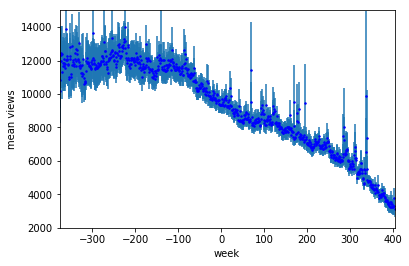

In [1390]:
g=df_s_w_naw.groupby("week")
b_w_st_dict_topic=defaultdict()
for week_name,series in g:
    concatenated = []
    for l in series.views_list.values:
        concatenated.extend(l) 
    b_w_st_dict_topic[week_name]={"mean_w":series.views_mean.mean(),"std_1":series.views_mean.sem(),
                            "count":series[~series.views_mean.isnull()].views_mean.count(),
                            "mean_w_all":np.mean(list(set(concatenated))),"count_all": len(set(concatenated))}

df_b_w_st_topic=pd.DataFrame.from_dict(b_w_st_dict_topic,orient="index")
print len(df_b_w_st_topic)
df_b_w_st_topic=df_b_w_st_topic[df_b_w_st_topic["count"]>10]
print len(df_b_w_st_topic)
df_b_w_st_topic.info()


plt.errorbar(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w, df_b_w_st_topic.std_1,linestyle='None')
plt.plot(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w,".b",linewidth = 1,ms=3)
plt.xlim(df_b_w_st_topic.index.min(),df_b_w_st_topic.index.max())
plt.ylim(2000,15000)
plt.xlabel("week")
plt.ylabel("mean views");

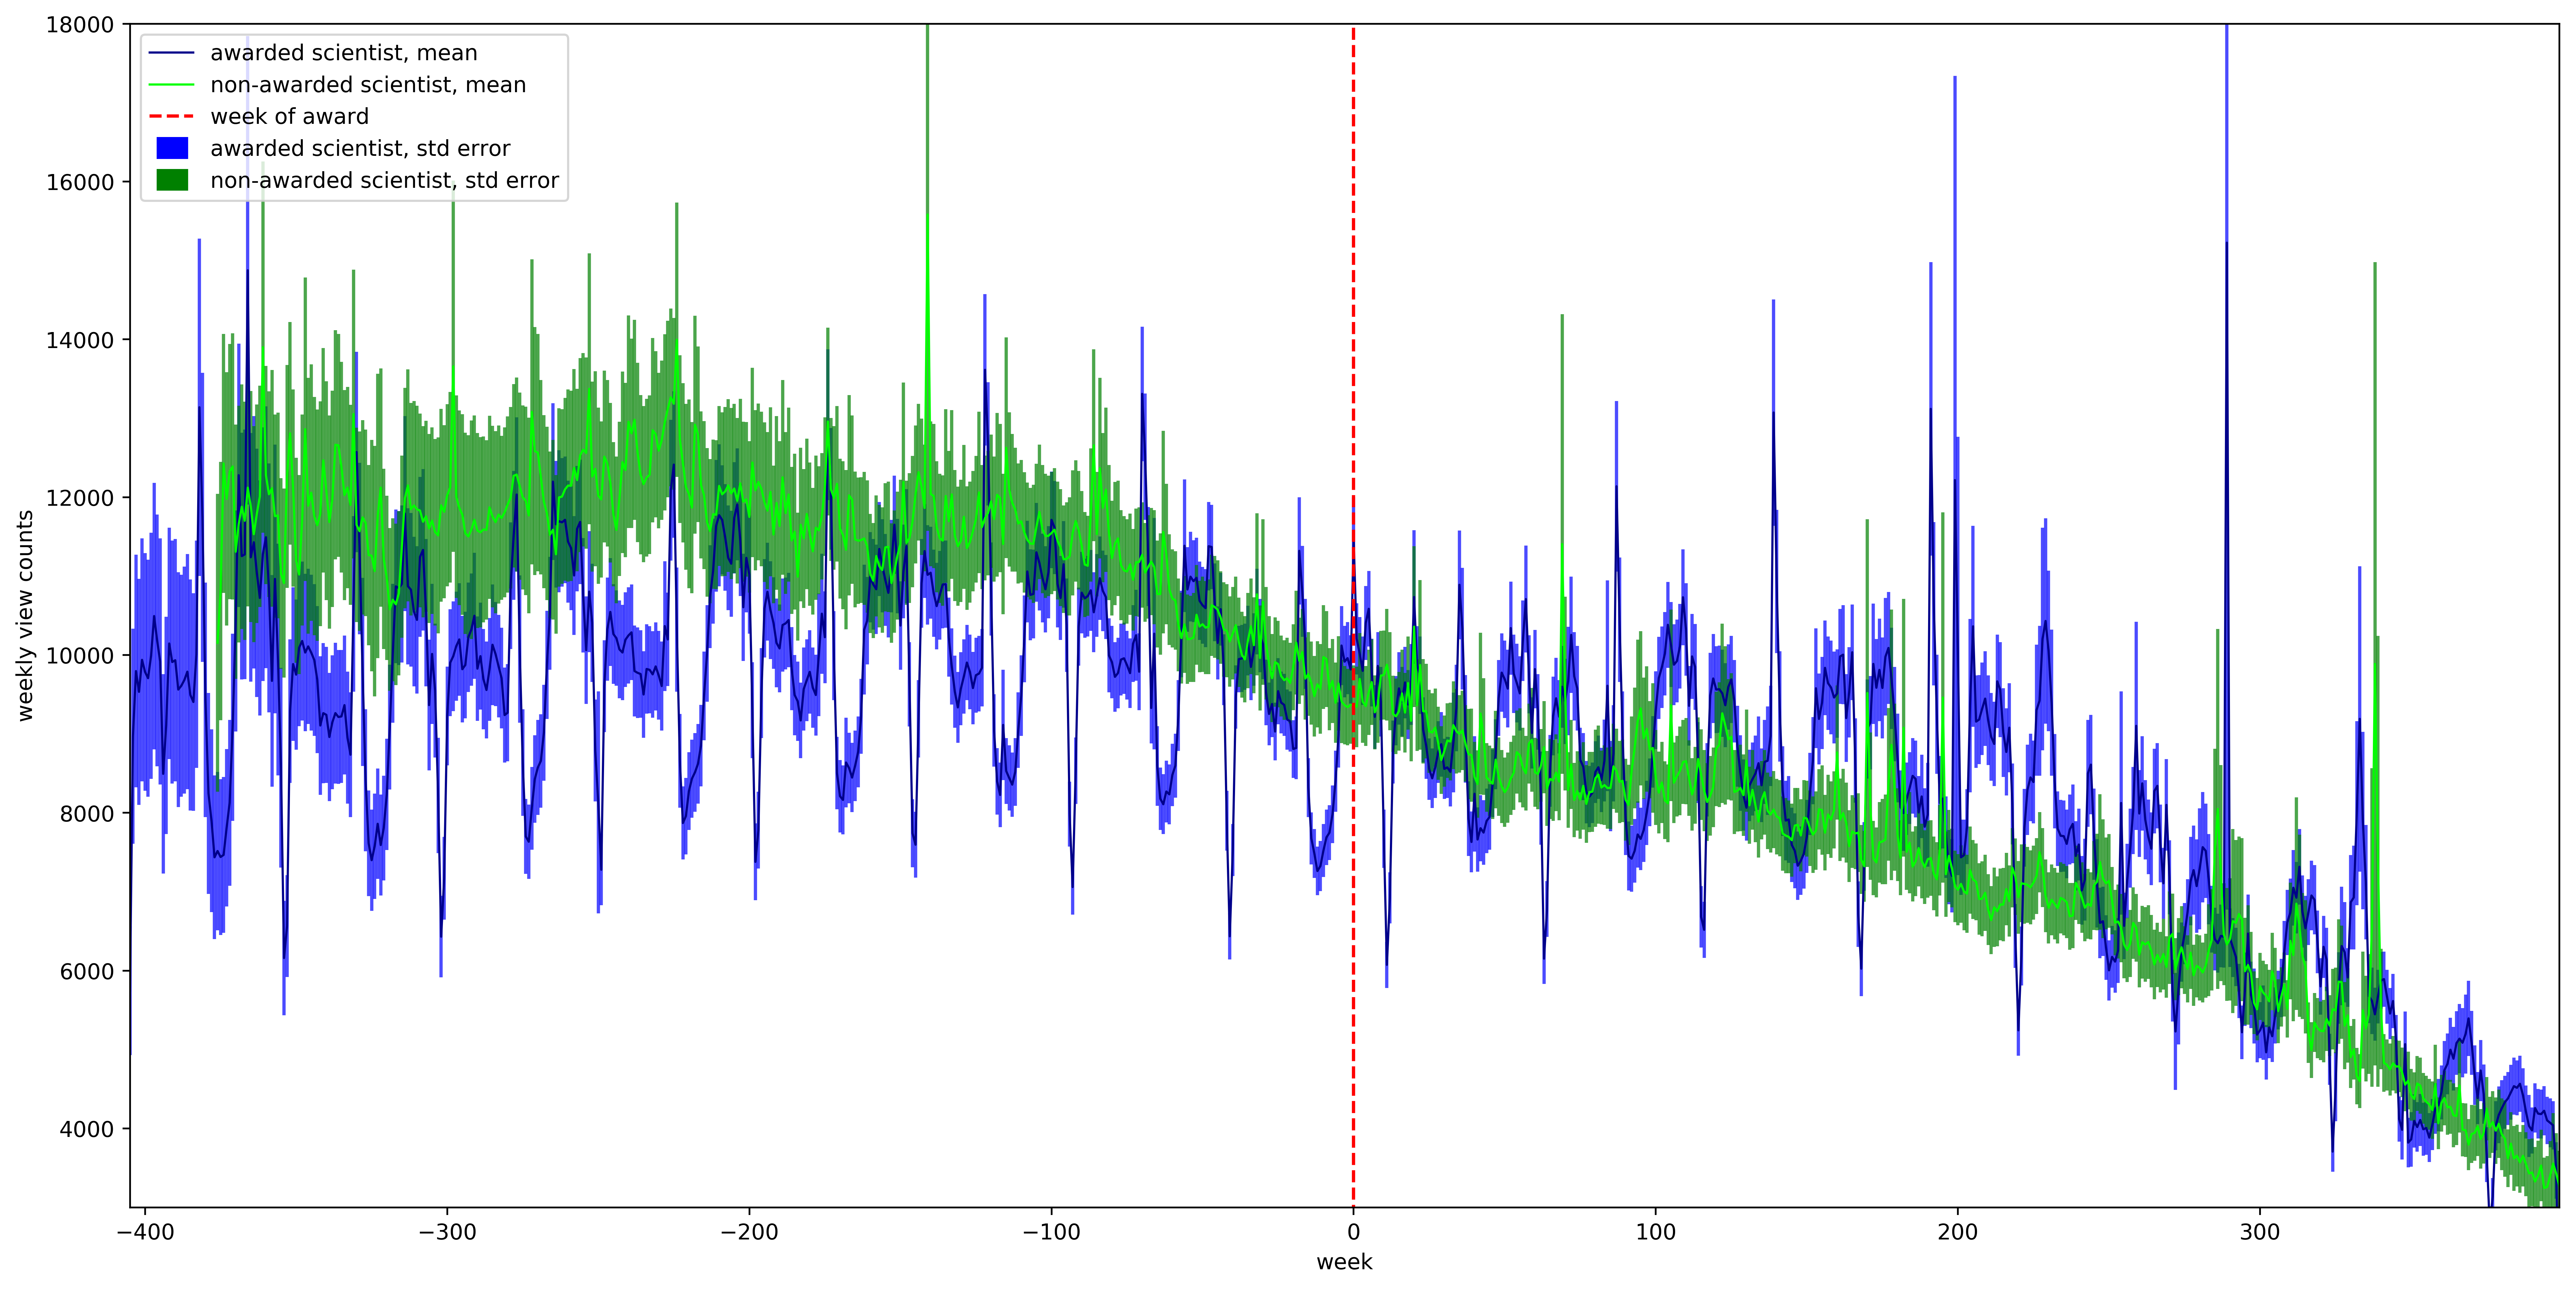

In [1338]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[20,10],dpi=500)

ax0.errorbar(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w, df_s_w_st_topic.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w,c="darkblue",linewidth = 1,ms=4,
         label="awarded scientist, mean")
ax0.set_xlim(df_s_w_st_topic.iloc[0].name,df_s_w_st_topic.iloc[-1].name)
ax0.set_ylim(3000,18000)
ax0.set_xlabel("week")
ax0.set_ylabel("weekly view counts")


ax0.errorbar(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w, df_b_w_st_topic.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w,c="lime",linewidth = 1,ms=4,
         label="non-awarded scientist, mean")
ax0.plot([0,0],[2000,20000],"r--",label="week of award")
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

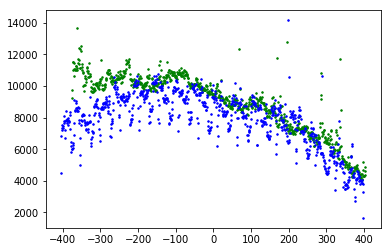

In [1395]:
#plt.errorbar(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w_all, df_s_w_st_topic.std_1,linestyle='None')
plt.plot(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w_all,".g",linewidth = 1,ms=3)
plt.plot(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w_all,".b",linewidth = 1,ms=3)

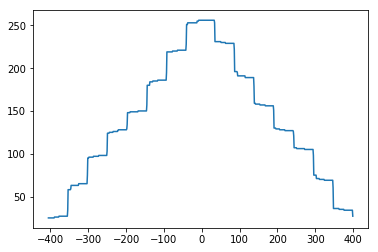

In [1397]:
df_s_w_st_topic["count"].plot()

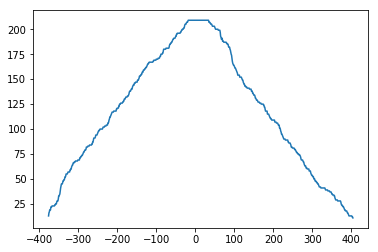

In [1396]:
df_b_w_st_topic["count"].plot()

In [1344]:
df_b_w_st_topic.loc[-1]

count      209.000000
mean_w    9366.405848
std_1      491.022338
Name: -1, dtype: float64

In [1345]:
df_b_w_st_topic.loc[0]

count      209.000000
mean_w    9371.650479
std_1      498.494982
Name: 0, dtype: float64

# Remove intersection topics



In [1432]:
sc_topic_aw_not_inter=defaultdict()
for k,v in sc_topic_aw3.iteritems():
    sc_topic_aw_not_inter[k]=[i for i in v if i not in intersection_topic]

df_s_w_aw2=df_s_w_aw.copy()   
df_s_w_aw2[['all_topics_len','topics_at_time','views_mean',
    "views_sem","views_list"]]= df_s_w_aw2.apply(lambda x: views_topic_mean_count(x,df_s_topic_new,
                                                                                 sc_topic_aw_not_inter), axis=1)

834
805
<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, -405 to 399
Data columns (total 5 columns):
count         805 non-null int64
count_all     805 non-null int64
mean_w        805 non-null float64
mean_w_all    805 non-null float64
std_1         805 non-null float64
dtypes: float64(3), int64(2)
memory usage: 37.7 KB


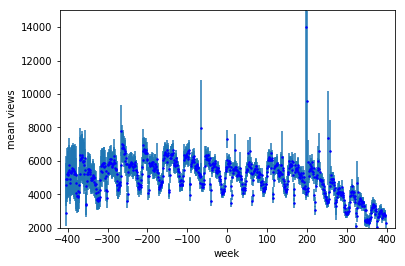

In [1436]:
g=df_s_w_aw2.groupby("week")
s_w_st_dict_topic2=defaultdict()
for week_name,series in g:
    concatenated = []
    for l in series.views_list.values:
        concatenated.extend(l) 
    #print concatenated
    s_w_st_dict_topic2[week_name]={"mean_w":series.views_mean.mean(), "std_1":series.views_mean.sem(),
                           "count":series[~series.views_mean.isnull()].views_mean.count(),
                                "mean_w_all":np.mean(list(set(concatenated))),"count_all": len(set(concatenated)) }

df_s_w_st_topic2=pd.DataFrame.from_dict(s_w_st_dict_topic2,orient="index")
print len(df_s_w_st_topic2)
df_s_w_st_topic2=df_s_w_st_topic2[df_s_w_st_topic2["count"]>10]
print len(df_s_w_st_topic2)
df_s_w_st_topic2.info()


plt.errorbar(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w, df_s_w_st_topic2.std_1,linestyle='None')
plt.plot(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w,".b",linewidth = 1,ms=3)
plt.xlim(-420,420)
plt.ylim(2000,15000)
plt.xlabel("week")
plt.ylabel("mean views");

In [1438]:
sc_topic_naw_not_inter=defaultdict()
for k,v in sc_topic_naw3.iteritems():
    sc_topic_naw_not_inter[k]=[i for i in v if i not in intersection_topic]
    
df_s_w_naw2=df_s_w_naw.copy()       
df_s_w_naw2[['all_topics_len','topics_at_time','views_mean',
            "views_sem","views_list"]]= df_s_w_naw2.apply(lambda x: views_topic_mean_count(x,df_b_topic_new,
                                                                                           sc_topic_naw_not_inter), axis=1)

805
805
<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, -375 to 401
Data columns (total 5 columns):
count         777 non-null int64
count_all     777 non-null int64
mean_w        777 non-null float64
mean_w_all    777 non-null float64
std_1         777 non-null float64
dtypes: float64(3), int64(2)
memory usage: 36.4 KB


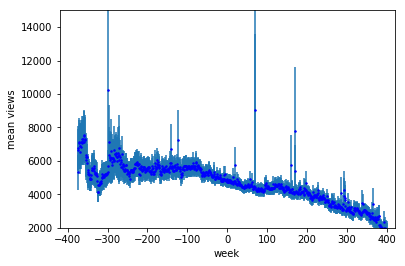

In [1439]:
g=df_s_w_naw2.groupby("week")
s_b_st_dict_topic2=defaultdict()
for week_name,series in g:
    concatenated = []
    for l in series.views_list.values:
        concatenated.extend(l) 
    #print concatenated
    s_b_st_dict_topic2[week_name]={"mean_w":series.views_mean.mean(), "std_1":series.views_mean.sem(),
                           "count":series[~series.views_mean.isnull()].views_mean.count(),
                                "mean_w_all":np.mean(list(set(concatenated))),"count_all": len(set(concatenated)) }

df_b_w_st_topic2=pd.DataFrame.from_dict(s_b_st_dict_topic2,orient="index")
print len(df_s_w_st_topic2)
df_b_w_st_topic2=df_b_w_st_topic2[df_b_w_st_topic2["count"]>10]
print len(df_s_w_st_topic2)
df_b_w_st_topic2.info()


plt.errorbar(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w, df_b_w_st_topic2.std_1,linestyle='None')
plt.plot(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w,".b",linewidth = 1,ms=3)
plt.xlim(-420,420)
plt.ylim(2000,15000)
plt.xlabel("week")
plt.ylabel("mean views");

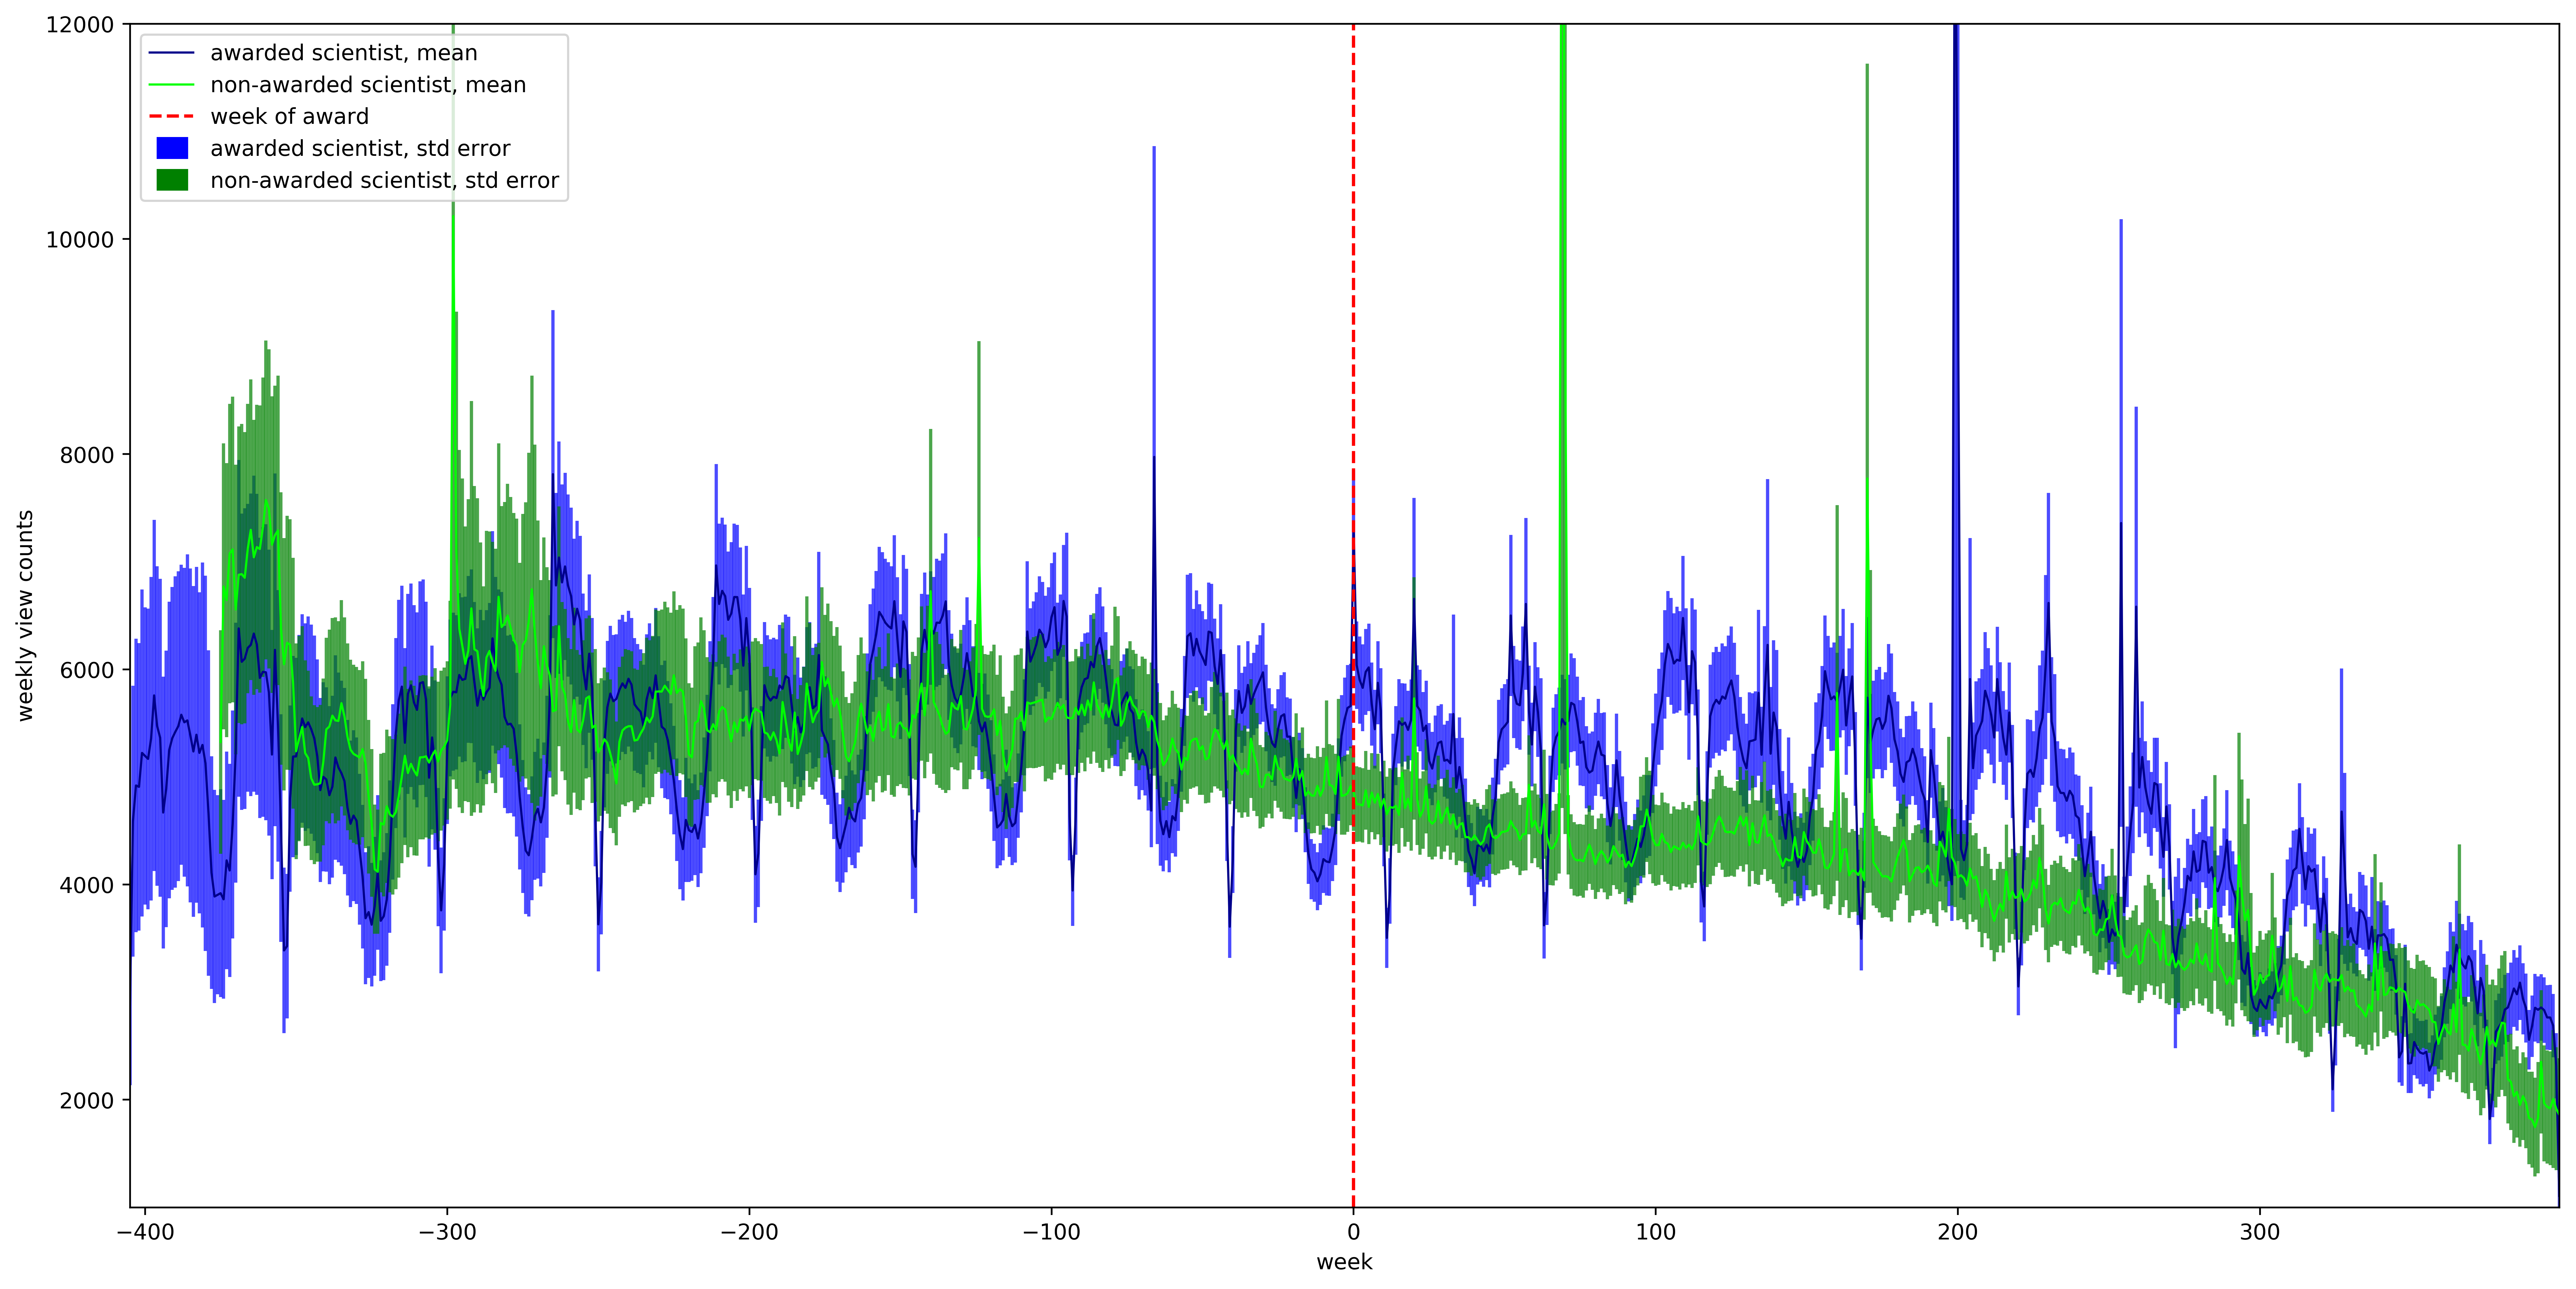

In [1443]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[20,10],dpi=500)

ax0.errorbar(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w, df_s_w_st_topic2.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w,c="darkblue",linewidth = 1,ms=4,
         label="awarded scientist, mean")
ax0.set_xlim(df_s_w_st_topic2.iloc[0].name,df_s_w_st_topic2.iloc[-1].name)
ax0.set_ylim(1000,12000)
ax0.set_xlabel("week")
ax0.set_ylabel("weekly view counts")


ax0.errorbar(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w, df_b_w_st_topic2.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w,c="lime",linewidth = 1,ms=4,
         label="non-awarded scientist, mean")
ax0.plot([0,0],[1000,20000],"r--",label="week of award")
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

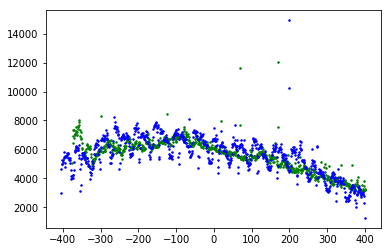

In [1444]:
plt.plot(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w_all,".g",linewidth = 1,ms=3)
plt.plot(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w_all,".b",linewidth = 1,ms=3)